# Basic analysis of a single ACCESS-OM3 run

In [1]:
from intake import cat
from xarray import DataTree, map_over_datasets
from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re
import os
import time
import intake


# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from parameters import *
test()



Functions from get_files.py imported!


Steps:
<!-- - In the gdata storage directory change the intake json file `cp intake_esm_ds.json intake_esm_ds_noah.json`
- `"file:///g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/archive/intake_esm_ds.csv.gz"`
 -->


Create a symbolic link (by default `archive` links to `/scratch/ps29/nd0349/access-om3/archive/mom6-cice6_ryf_rel_wav`):
- `rm /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive`
- `ln -s /g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive`

In [2]:
# %%bash
# rm /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_iaf_rel/archive
# ln -s /g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_iaf_rel /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_iaf_rel/archive
# # 1deg_jra55_iaf-experiment-70159801

In [3]:
# %%bash
# rm /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_iaf_rel/archive
# ln -s /g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_iaf_rel /g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_iaf_rel/archive
# #mom6-cice6_ryf_rel_wav_rand

In [4]:
# %%bash
# rm /g/data/ps29/nd0349/spack/0.22/spack-release/access-om3/wav_config_iaf/archive
# ln -s /g/data/ps29/nd0349/runs/access-om3/archive/wav_config_iaf /g/data/ps29/nd0349/spack/0.22/spack-release/access-om3/wav_config_iaf/archive
# # wav_iaf_rel
π = np.pi

In [2]:
from access_nri_intake.source import builders

builders.__all__

['AccessOm2Builder',
 'AccessOm3Builder',
 'Mom6Builder',
 'AccessEsm15Builder',
 'AccessCm2Builder',
 'ROMSBuilder',
 'WoaBuilder']

In [3]:
model = 'access-om3'
experiment = "IC4M3-MCW-100km_jra_ryf"
# "mom6-cice6_ryf_rel"
#"IC4M8-MCW-100km_jra_ryf"
#'wav_config_iaf'
# "IC4-IC4M2-MCW_100km_jra_iaf"
directory = "archive" # "archive" or "work"
drive = "gdata" # "scratch" or "gdata"
override_datastore = False

iaf = "ryf" not in experiment
if drive == "gdata":
    PATH = f"/g/data/ps29/nd0349/runs/{model}/{directory}/{experiment}"  # Example ACCESS-OM2 output
else:
    PATH = f"/scratch/ps29/nd0349/{model}/{directory}/{experiment}"  # Example ACCESS-OM2 output
datastore_name = f"datastores/datastore_{model}_{experiment}.json"  # adjust if builder saves differently

if not os.path.exists(datastore_name) or override_datastore:
    start = time.time()
    
    builder = builders.AccessOm3Builder(path=PATH).build()
    builder.save(
        name=datastore_name[:-5], # remove .json
        description="An example datastore for ACCESS-OM3",
    )
    
    elapsed = time.time() - start
    print(f"✅ Datastore built in {elapsed:.2f} seconds.")
else:
    print(f"ℹ️ Datastore {datastore_name} already exists — skipping build.")

ℹ️ Datastore datastores/datastore_access-om3_IC4M3-MCW-100km_jra_ryf.json already exists — skipping build.


In [4]:
import os
output_frequency = "1mon" # "1day" "1mon"
figpath = f"/home/566/nd0349/access-om3-analysis/figures/{experiment}"
os.makedirs(figpath, exist_ok=True)

In [5]:
# import pandas as pd

# # Load the CSV
# df = pd.read_csv('/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/intake_esm_ds.csv.gz')

# # Replace the old path with the new one
# old_path = "/g/data/ps29/nd0349/spack/0.22/spack-release/mom6-cice6_configs/mom6-cice6_ryf_rel_wav/archive/output000/"
# new_path = "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/"

# df['path'] = df['path'].str.replace(old_path, new_path)

# # Save the updated CSV
# df.to_csv('/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel_wav/intake_esm_ds_noah.csv.gz', index=False)



In [6]:
client = Client(threads_per_worker=1, memory_limit=0)
client

<Client: 'tcp://127.0.0.1:42611' processes=7 threads=7, memory=0 B>

In [7]:
esm_datastore = intake.open_esm_datastore(
    f"./{datastore_name}", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ] # This is important
)

esm_datastore

In [8]:
esm_datastore.unique().frequency
esm_datastore.search(frequency=output_frequency).unique().variable#[0:10]
# esm_datastore.df.frequency.unique()

['ANGLE',
 'ANGLET',
 'NCAT',
 'Tair_m',
 'Tsfc_m',
 'VGRDa',
 'VGRDb',
 'VGRDi',
 'VGRDs',
 'afsd_m',
 'afsdn_m',
 'aice_m',
 'aice_ww_m',
 'aicen_m',
 'albice_m',
 'albsni_m',
 'albsno_m',
 'alidf_ai_m',
 'alidr_ai_m',
 'alvdf_ai_m',
 'alvdr_ai_m',
 'blkmask',
 'congel_m',
 'dafsd_latg_m',
 'dafsd_latm_m',
 'dafsd_newi_m',
 'dafsd_wave_m',
 'dafsd_weld_m',
 'daidtd_m',
 'daidtt_m',
 'diam_ww_m',
 'divu_m',
 'dvidtd_m',
 'dvidtt_m',
 'evap_ai_m',
 'fcondtop_ai_m',
 'fcondtopn_ai_m',
 'fhocn_ai_m',
 'flat_ai_m',
 'flatn_ai_m',
 'flwdn_m',
 'flwup_ai_m',
 'fmeltt_ai_m',
 'fmelttn_ai_m',
 'frazil_m',
 'fresh_ai_m',
 'frzmlt_m',
 'fsalt_ai_m',
 'fsalt_m',
 'fsdperim_m',
 'fsdrad_m',
 'fsens_ai_m',
 'fsensn_ai_m',
 'fsurfn_ai_m',
 'fswabs_ai_m',
 'fswdn_m',
 'fswthru_ai_m',
 'fswup_m',
 'hi_m',
 'hice_ww_m',
 'hs_m',
 'ice_present_m',
 'meltb_m',
 'meltl_m',
 'melts_m',
 'meltt_m',
 'opening_m',
 'rain_ai_m',
 'scale_factor_m',
 'shear_m',
 'sice_m',
 'sifb_m',
 'snoice_m',
 'snow_ai_m',
 

In [9]:
# speed 

In [10]:
esm_datastore_filtered = esm_datastore.search(
    variable=["aice_m", "hi_m", "fsdrad_m", "wave_sig_ht_m"], frequency=output_frequency, #require_all_on="path"
)
esm_datastore_filtered

## Load in CICE data

In [11]:
%%time
xarray_open_kwargs = {"chunks": {"time": 1, "nj": -1, "ni": -1}}
# var = 'aice'
# first_file_id = esm_datastore.df['file_id'].unique()[0]
ds_cice = esm_datastore_filtered.to_dask(xarray_open_kwargs=xarray_open_kwargs) # .search(file_id=first_file_id)
ds_cice["time"] = ds_cice.time.to_pandas()# - timedelta(hours=12)
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds_cice = ds_cice.rename({name: name[:-2] for name in ds_cice.data_vars if name.endswith('_m')})
ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = grid_ds['tarea']
ds_cice

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


CPU times: user 3.49 s, sys: 603 ms, total: 4.1 s
Wall time: 15 s


<xarray.Dataset> Size: 48MB
Dimensions:      (time: 12, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 96B 1900-01-16 12:00:00 ... 1900-12-16 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Dimensions without coordinates: nj, ni
Data variables:
    aice         (time, nj, ni) float64 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    hi           (time, nj, ni) float64 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 10MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    tarea        (nj, ni) float64 864kB ...
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,time: mean,time: mean,,,,,ti...
    intake_esm_attrs:variable_units:          radians,radians,m,C,C,1,1,1,1,1...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   seaIce.1mon.nbnd:2.nc:5.nf:12.n...

### Plot some basic CICE variables

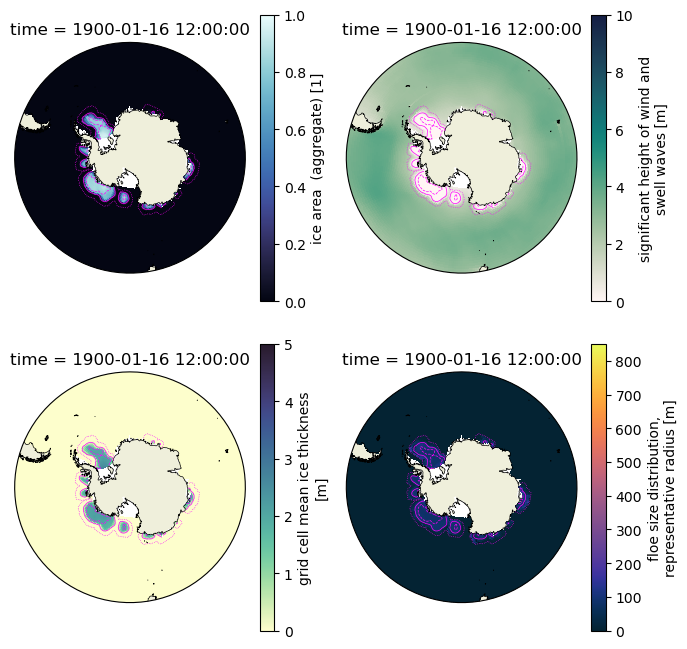

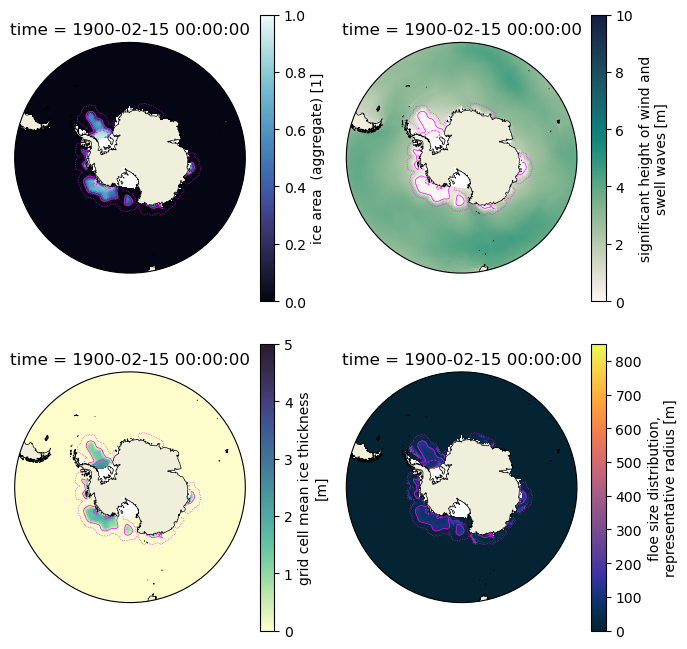

In [ ]:
hemisphere = "south"
var_list = ["aice", "wave_sig_ht", "hi", "fsdrad"]

for time_idx in np.arange(0, len(ds_cice.time), 1):
    time = ds_cice.isel(time=time_idx).time
    
    fig, axes, projection = basic_axis([2, 2], hemisphere=hemisphere)
    
    for i, var in enumerate(var_list):
        if var not in ds_cice:
            print(f"Skipping {var}, not in dataset.")
            continue  # skip to the next variable
        settings = get_plot_settings(var)
        ds_cice[var].sel(time=time).plot(ax=axes[i], 
                                        x="TLON", 
                                        y="TLAT", 
                                        cmap=settings.get("cmap"),
                                        vmin=settings.get("vmin"),
                                        vmax=settings.get("vmax"),
                                        transform=ccrs.PlateCarree()
        )
        add_ice_contours(axes[i], ds_cice.isel(time=time_idx), hemisphere, projection)

    if iaf:
        time_val = pd.to_datetime(ds_cice.isel(time=time_idx).time.values)
        date_str = time_val.strftime("%Y%m%d")
    else:
        dt_iso = ds_cice.isel(time=time_idx).time.values.item().isoformat()
        date_str = pd.to_datetime(dt_iso).strftime("%Y%m%d")

    # for ax in axes:
        # if hemisphere == "north":
            # ax.set_extent([0,360,50,90], crs=ccrs.PlateCarree())
    fig.savefig(os.path.join(figpath, f"basic_ice_{model}_{experiment}_{date_str}_{hemisphere}.png"), dpi=300)
    plt.show()

In [13]:
import imageio.v2 as imageio
hemisphere = "south"
pattern = os.path.join(figpath, f"basic_ice_{model}_{experiment}_*_{hemisphere}.png")
files = sorted(glob.glob(pattern))

images = [imageio.imread(f) for f in files]
imageio.mimsave(os.path.join(figpath, f"ice_{model}_{experiment}_{hemisphere}.gif"),
                images,
                fps=2)    # seconds per frame

## Load in MOM data

In [ ]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

datastore_filtered = esm_datastore.search(realm="ocean", frequency="1mon")
# datastore_filtered_grid = esm_datastore.search(realm="ocean", frequency="fx")

available_variables(datastore_filtered)

In [ ]:
# esm_datastore.search(realm="ocean", frequency="1mon")# .unique()

In [ ]:
# %%time
xarray_open_kwargs = {"chunks": {"time": 1, "nj": -1, "ni": -1}}
# var = 'aice'
# first_file_id = esm_datastore.df['file_id'].unique()[0]
var_list_daily = ["tos", "sos"]
var_list = ["speed", "mlotst"]# , "mlotst"]
ds_mom_daily = esm_datastore.search(frequency="1day", variable=["tos", "sos"]).to_dask()
ds_mom_daily_monthly = ds_mom_daily.resample(time="1MS").mean()
ds_mom_daily_monthly = ds_mom_daily_monthly.assign_coords(
    time = ds_mom_daily_monthly.time + pd.Timedelta(days=15, hours=12)
)
ds_mom = esm_datastore.search(frequency=output_frequency, variable=var_list).to_dask()
ds_mom = xr.merge([ds_mom, ds_mom_daily_monthly], compat="override")

# ds_mom["time"] = ds_cice.time.to_pandas() #- timedelta(hours=12)
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
ds_mom

# Add grid to dataset
ds_mom.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_mom.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_mom['tarea'] = grid_ds['tarea']
ds_mom = ds_mom.rename({"xh": "ni", "yh": "nj"})
var_list = var_list_daily + var_list
ds_mom



# mom_files = sorted(glob.glob(f"{PATH}/access-om3.mom6.*.nc"))#[::100]
# ds_mom = xr.open_mfdataset(mom_files,
#                         combine='by_coords',
#                         data_vars='minimal',
#                         coords='minimal',
#                         compat='override'
#                         )
# ds_mom.coords['TLON'] = np.degrees(grid_ds['tlon'])
# ds_mom.coords['TLAT'] = np.degrees(grid_ds['tlat'])
# ds_mom

In [ ]:
# esm_datastore.search(frequency='1day').unique().variable
# esm_datastore.search(frequency='1day', variable=["tos"])
# output_frequency = '1mon'


### Plot some basic MOM outputs

In [106]:
plot_settings = {
    # CICE
    "aice": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "fsdrad": {"cmap": cmo.thermal, "vmin": 0, "vmax": 850},
    "hi": {"cmap": cmo.deep, "vmin": 0, "vmax": 5},
    "hs": {"cmap": cmo.amp, "vmin": 0, "vmax": 0.5},
    "iage": {"cmap": cmo.dense, "vmin": 0, "vmax": 2},
    "icespd": {"cmap": cmo.amp, "vmin": 0, "vmax": 0.5},
    "hfs": {"cmap": cmo.amp, "vmin": 0, "vmax": 1},
    "tice": {"cmap": cmo.balance, "vmin": -30, "vmax": 0},
    "uvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "vvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "strength": {"cmap": cmo.matter, "vmin": 0, "vmax": 50e3},
    "divu": {"cmap": cmo.curl, "vmin": -1e-5, "vmax": 1e-5},
    "shear": {"cmap": cmo.curl, "vmin": 0, "vmax": 1e-5},
    "Tair": {"cmap": cmo.thermal, "vmin": -30, "vmax": 40},
    "uatm": {"cmap": cmo.balance, "vmin": -20, "vmax": 20},
    "vatm": {"cmap": cmo.balance, "vmin": -20, "vmax": 20},
    "Qref": {"cmap": cmo.dense, "vmin": 0, "vmax": 25},
    "fswdn": {"cmap": cmo.solar, "vmin": 0, "vmax": 1200},
    "flwdn": {"cmap": cmo.thermal, "vmin": 100, "vmax": 500},
    "snow_ai": {"cmap": cmo.gray, "vmin": 0, "vmax": 1.5e-6},
    "snow": {"cmap": cmo.gray, "vmin": 0, "vmax": 0.5},
    "sst": {"cmap": cmo.thermal, "vmin": -2, "vmax": 30},
    "sss": {"cmap": cmo.haline, "vmin": 32, "vmax": 37},
    "uocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "vocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "wave_sig_ht": {"cmap": cmo.tempo, "vmin": 0, "vmax": 10}, 
    # MOM6
    "tos": {"cmap": cmo.thermal, "vmin": -8, "vmax": 20},
    "sos": {"cmap": cmo.haline, "vmin": 33, "vmax": 35},
    "speed": {"cmap": "viridis", "vmin": 0, "vmax": 0.5}, 
    "mlotst": {"cmap": "viridis", "vmin": 0, "vmax": 100}, 
    # WW3
    "HS": {"cmap": cmo.tempo, "vmin": 0, "vmax": 10}, 
    "ICE": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "ICEH": {"cmap": cmo.deep, "vmin": 0, "vmax": 5},
    "ICEF": {"cmap": cmo.thermal, "vmin": 0, "vmax": 1700},
    "T02": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "T0M1": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "T0M1": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "FP": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "DIR": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "EF": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "IC1": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "IC5": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "THM": {"cmap": plt.cm.twilight_shifted, "vmin": -np.pi, "vmax": np.pi},
    "FP0": {"cmap": "viridis", "vmin": 0, "vmax": 0.5},

}


In [116]:
# ds_mom.isel(time=0)['speed'].plot()
# ds_mom
ds_mom.time

<xarray.DataArray 'time' (time: 24)> Size: 192B
array([cftime.DatetimeNoLeap(1900, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 4, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 5, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 5, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 6, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 7, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 7, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 8, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 8, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 10, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1900, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 192B 1900-01-01 00:00:00 ... 1900-12-16 12:00:00
Attributes:
    long_name:      time
    axis:           T
    calendar_type:  NOLEAP
    bounds:         time_bnds

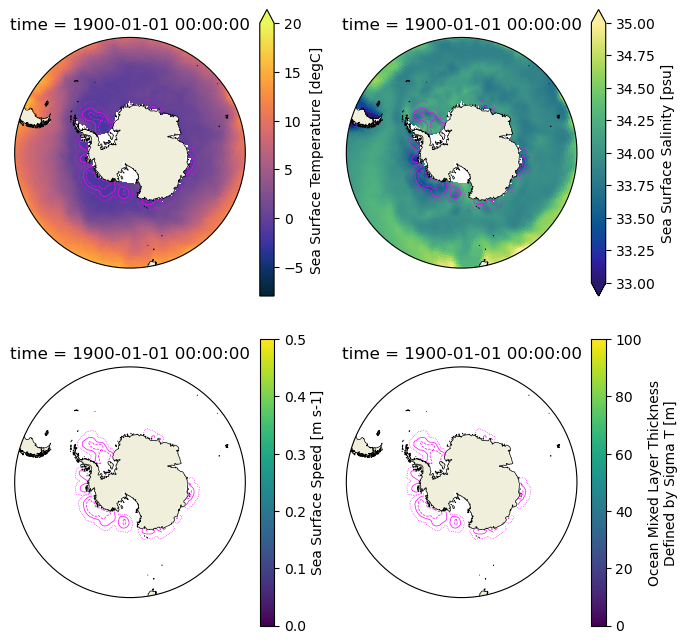

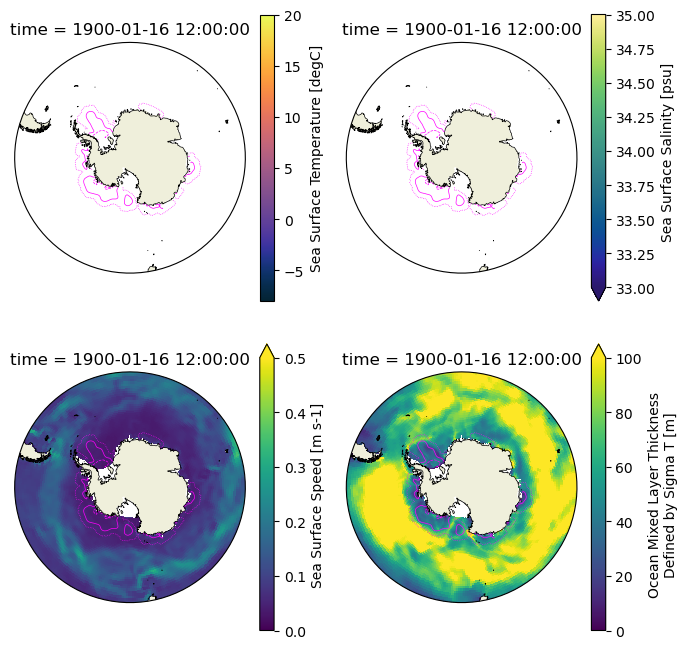

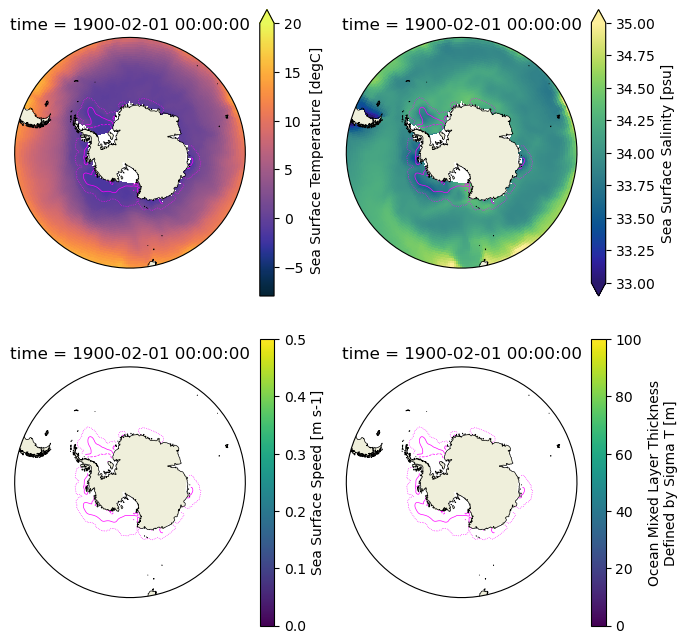

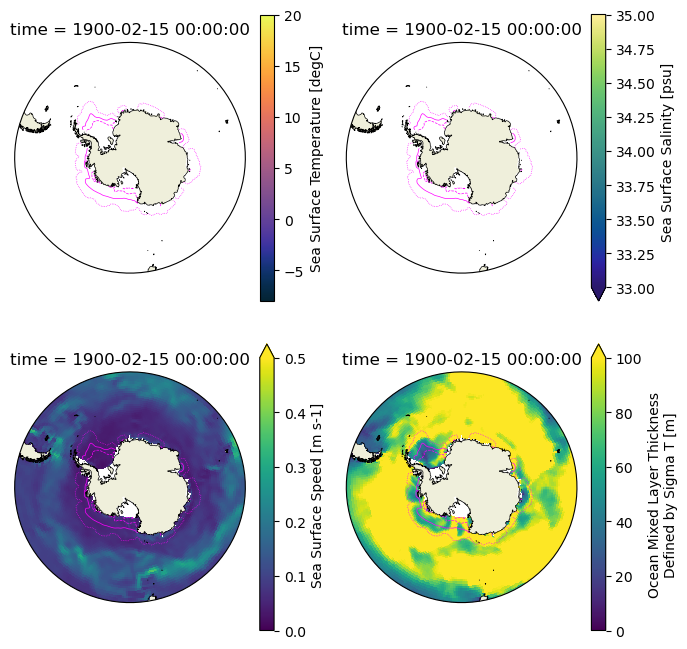


KeyboardInterrupt

Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/asyncio/base_events.py", line 654, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/nanny.py", line 985, in run
    await worker.finished()
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/core.py", line 494, in finished
    await self._event_finished.wait(

Error in callback <function _draw_all_if_interactive at 0x1524bca9dda0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



Error in callback <function flush_figures at 0x152458f7c9a0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [108]:
hemisphere = "south"

for time_idx in np.arange(0, len(ds_mom.time), 1):
    time = ds_mom.isel(time=time_idx).time
    fig, axes, projection = basic_axis([2,2], hemisphere=hemisphere)
    
    for i, var in enumerate(var_list):
        # settings = get_plot_settings(var)
        settings = plot_settings[var]
        ds_mom[var].isel(time=time_idx).plot(ax=axes[i], 
                                        x="TLON", 
                                        y="TLAT", 
                                        cmap=settings.get("cmap"),
                                        vmin=settings.get("vmin"),
                                        vmax=settings.get("vmax"),
                                        transform=ccrs.PlateCarree()
        )
        add_ice_contours(axes[i], ds_cice.isel(time=time_idx), hemisphere, projection)

    if iaf:
        time_val = pd.to_datetime(ds_mom.isel(time=time_idx).time.values)
        date_str = time_val.strftime("%Y%m%d")
    else:
        dt_iso = ds_cice.isel(time=time_idx).time.values.item().isoformat()
        date_str = pd.to_datetime(dt_iso).strftime("%Y%m%d")

    # for ax in axes:
        # if hemisphere == "north":
            # ax.set_extent([0,360,50,90], crs=ccrs.PlateCarree())
    fig.savefig(os.path.join(figpath, f"basic_ocn_{model}_{experiment}_{date_str}_{hemisphere}.png"), dpi=300)
    plt.show()

In [ ]:
# experiment
pattern = os.path.join(figpath, f"basic_ocn_{model}_{experiment}_*_{hemisphere}.png")
files = sorted(glob.glob(pattern))

images = [imageio.imread(f) for f in files]
imageio.mimsave(os.path.join(figpath, f"ocn_{model}_{experiment}_{hemisphere}.gif"),
                images,
                fps=2)    # seconds per frame

In [40]:
figpath = "/home/566/nd0349/access-om3-analysis/figures/IC4M8-MCW-100km_jra_ryf"
experiment = "IC4M8-MCW-100km_jra_ryf"

## Load in WW3 data

In [17]:
ds_ww3 = esm_datastore.search(variable=["EF", "HS", "ICE", "ICEF", "ICEH", "THM", "FP0"], require_all_on="path").to_dask()

#xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
# var = 'aice'
#ds = esm_datastore_filtered.to_dask(xarray_open_kwargs=xarray_open_kwargs)
# ds_ww3
pattern = f"/scratch/ps29/nd0349/access-om3/archive/{experiment}/output000/access-om3.ww3.hi.*.nc"
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"No files matched: {pattern}")
ds_grid_ww3 = xr.open_dataset(files[0])
ds_ww3.coords['lon'] = ds_grid_ww3['lon']
ds_ww3.coords['lat'] = ds_grid_ww3['lat']
ds_ww3

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/core.py:321: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  records = grouped.get_group(internal_key).to_dict(orient='records')


<xarray.Dataset> Size: 5GB
Dimensions:  (time: 396, ny: 300, nx: 360, freq: 25)
Coordinates:
  * time     (time) object 3kB 1900-01-02 00:00:00 ... 1902-02-01 00:00:00
    lon      (ny, nx) float64 864kB ...
    lat      (ny, nx) float64 864kB ...
Dimensions without coordinates: ny, nx, freq
Data variables:
    HS       (time, ny, nx) float32 171MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICE      (time, ny, nx) float32 171MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEF     (time, ny, nx) float32 171MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    THM      (time, ny, nx) float32 171MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    EF       (time, freq, ny, nx) float32 4GB dask.array<chunksize=(1, 25, 300, 360), meta=np.ndarray>
    FP0      (time, ny, nx) float32 171MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEH     (time, ny, nx) float32 171MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    intake_esm_vars:                          ['HS', 'ICE', 'ICEF', 'THM', 'E...
    intake_esm_attrs:file_id:                 wave.fx.freq:25.nx:360.ny:300
    intake_esm_attrs:frequency:               fx
    intake_esm_attrs:variable:                EF,FP0,HS,ICE,ICEF,ICEH,T01,T02...
    intake_esm_attrs:variable_long_name:      1D spectral density,Peak freque...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,,,,
    intake_esm_attrs:variable_units:          m2 s,s-1,m,nd,m,m,s,s,s,rad,m s...
    intake_esm_attrs:realm:                   wave
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   wave.fx.freq:25.nx:360.ny:300

### Plot some basic WW3 variables

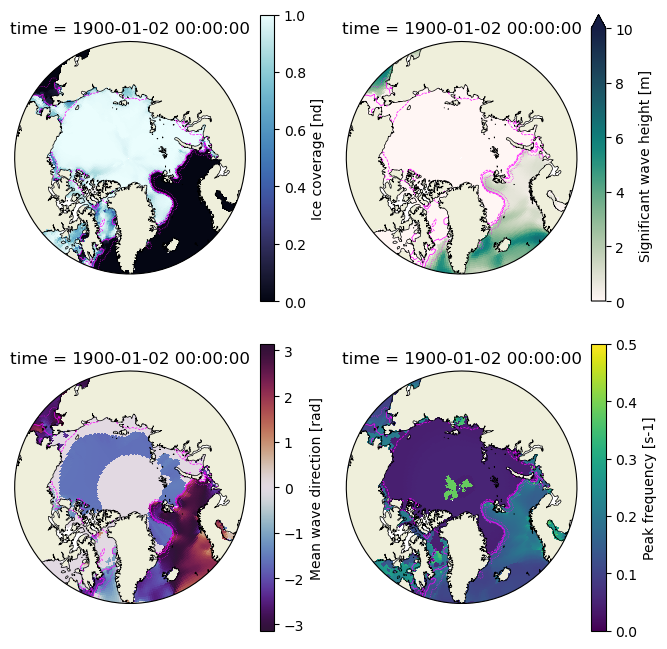

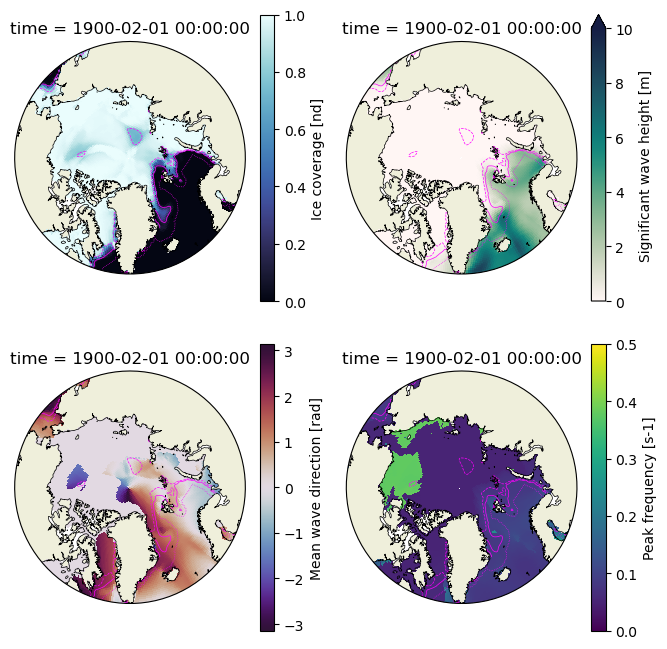

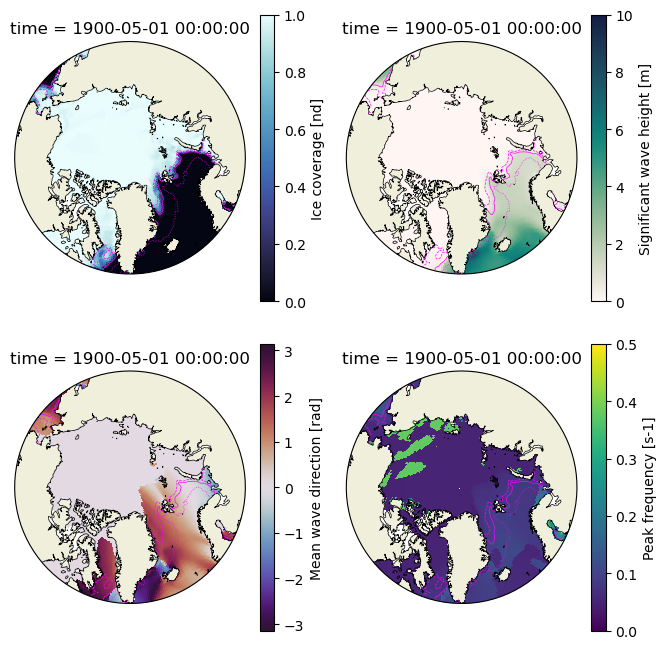

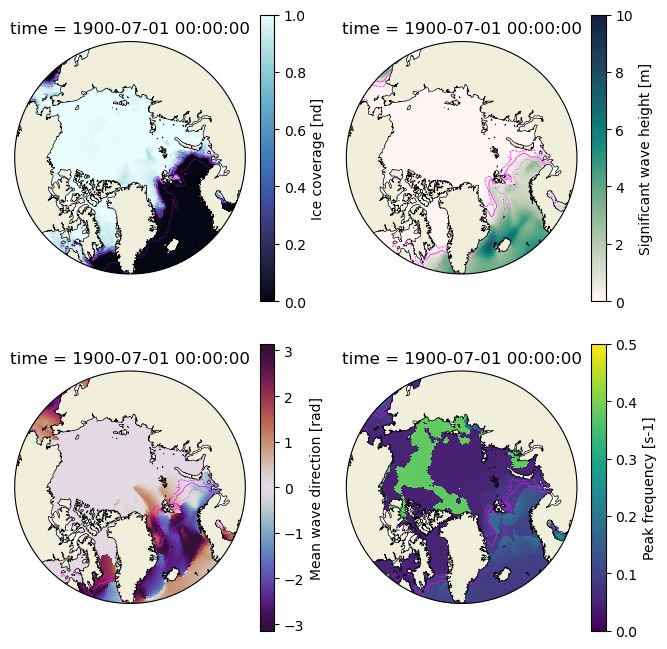

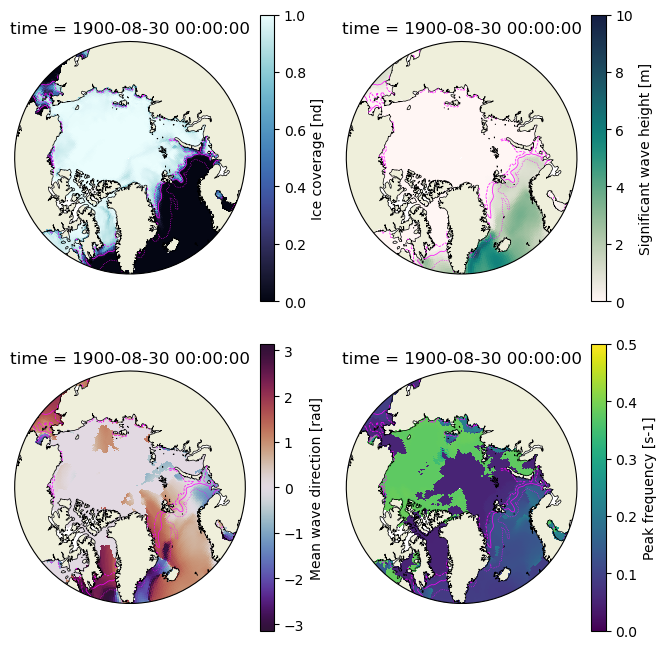

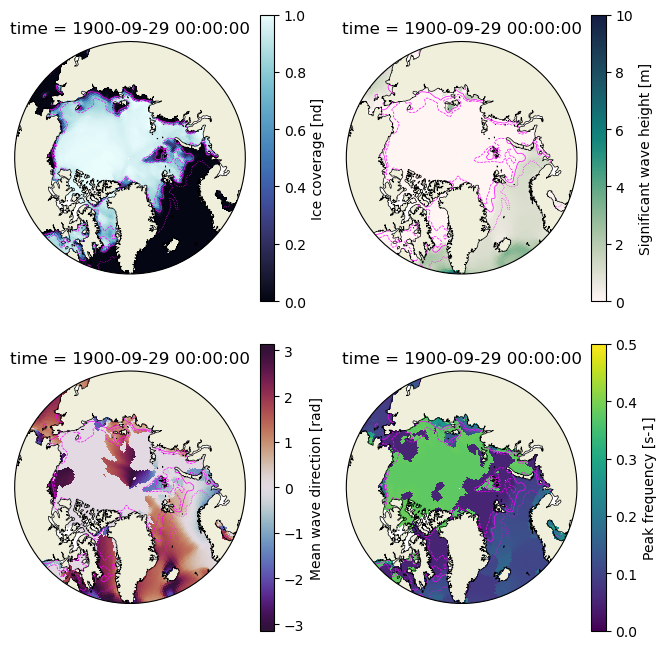

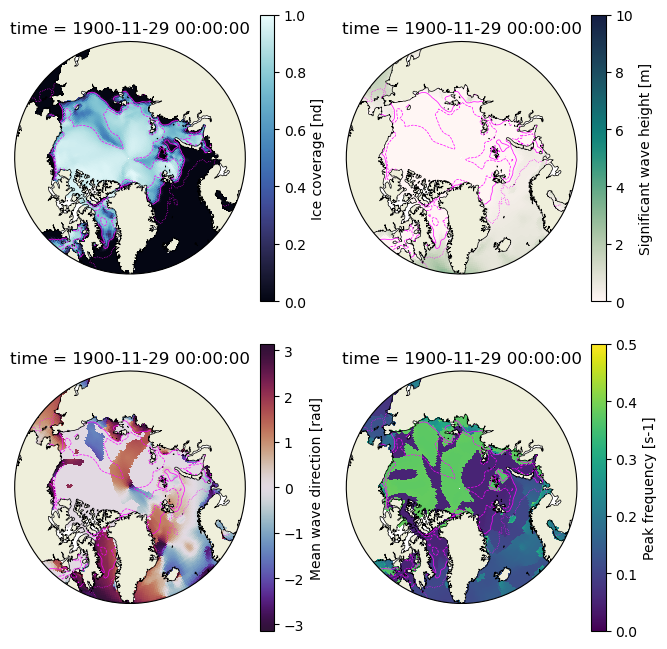

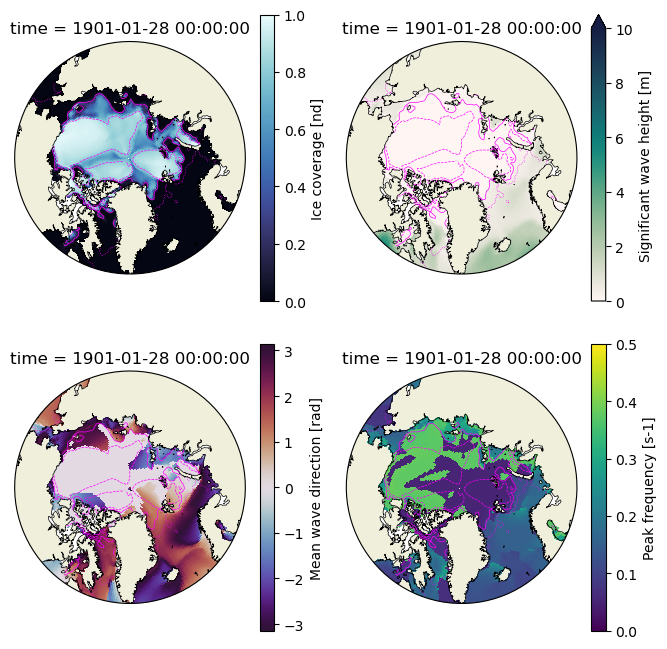

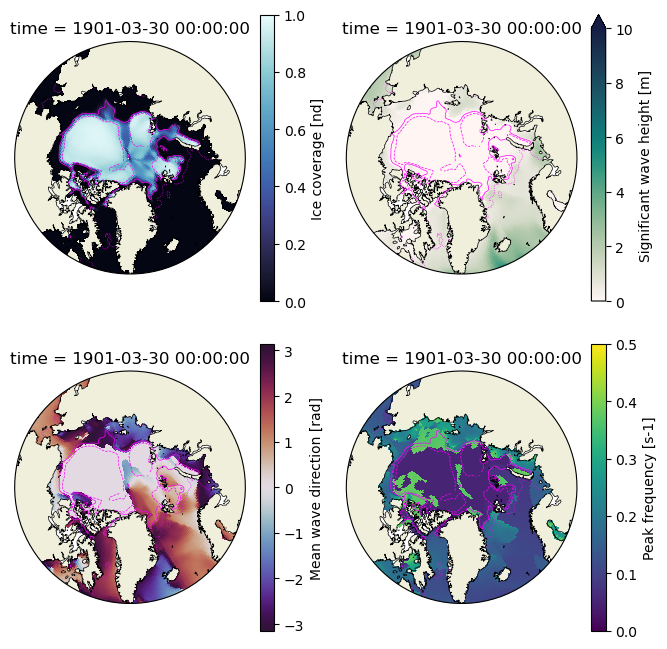

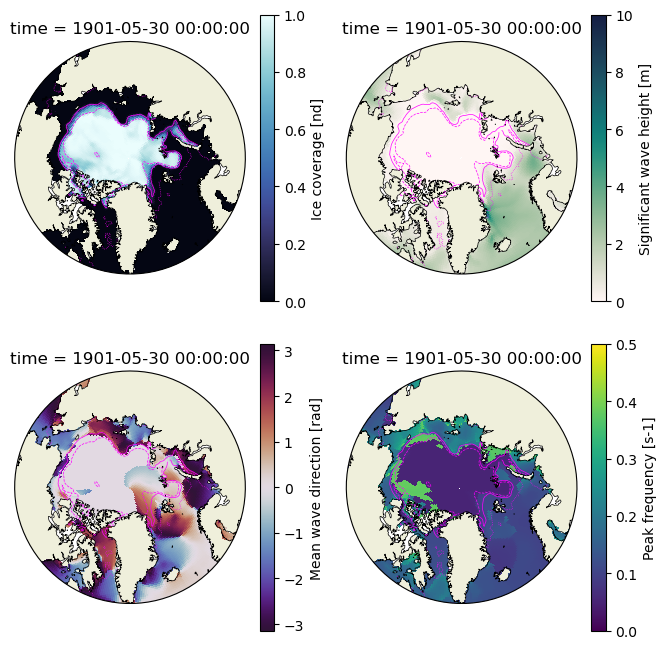

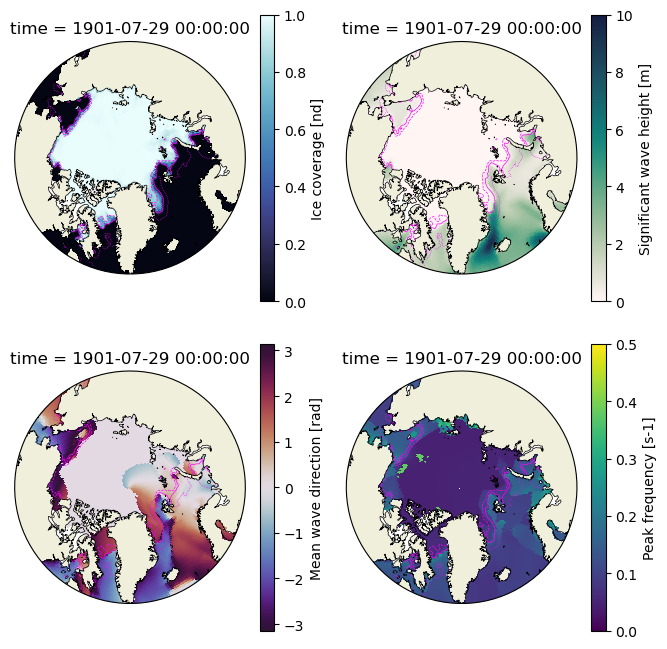

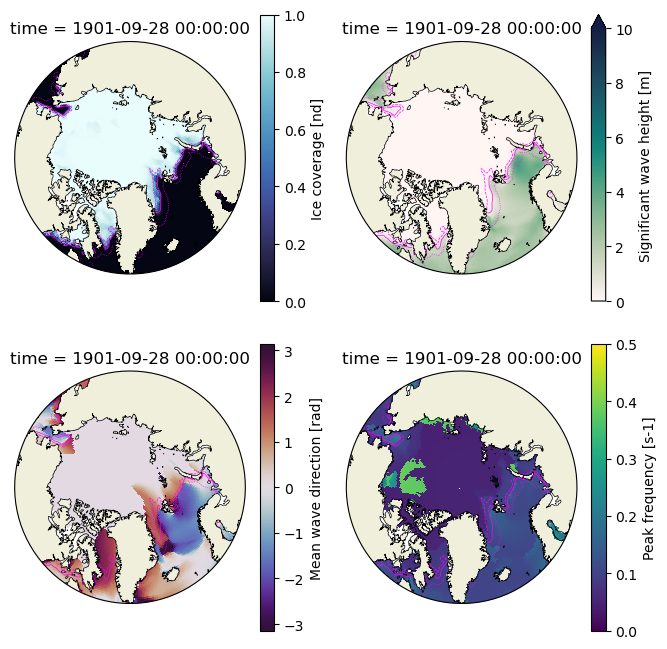

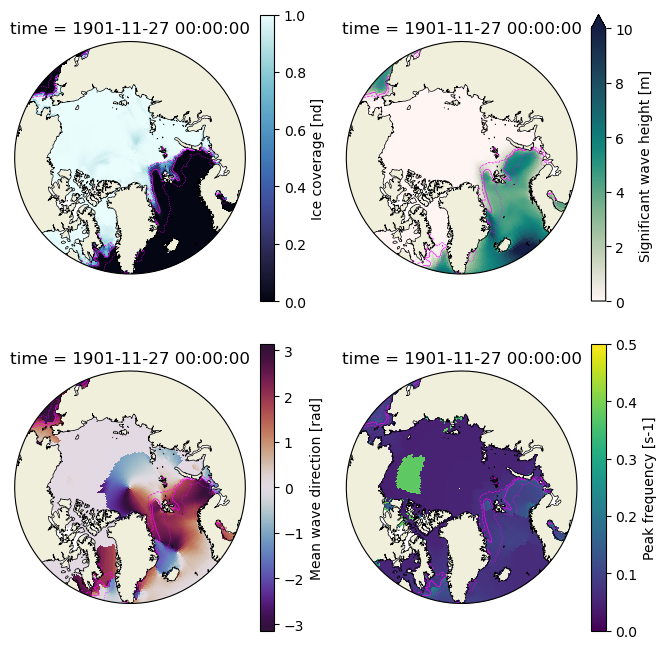

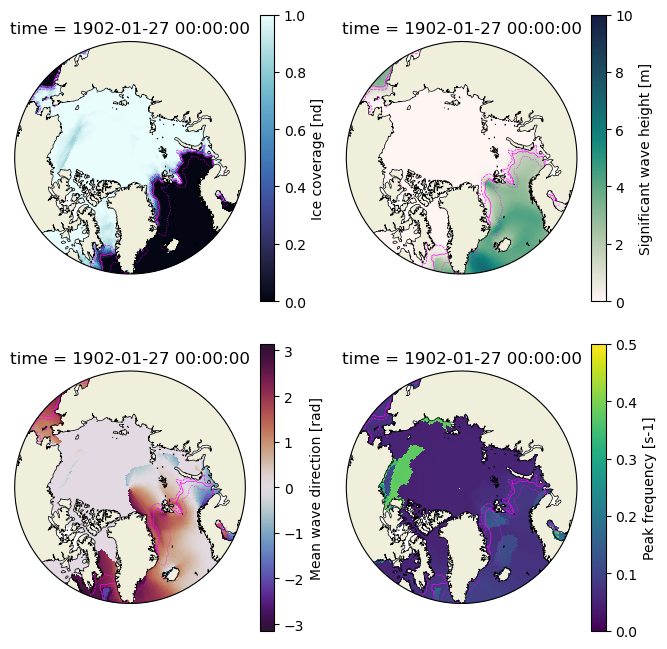

In [21]:
hemisphere = "north"

for time_idx in np.arange(0, len(ds_cice.time), 30):
    time = ds_cice.isel(time=time_idx).time
    fig, axes, projection = basic_axis([2,2], hemisphere=hemisphere)
    
    vars = ["ICE", "HS", "THM", "FP0"]
    for i, var in enumerate(vars):
        settings = get_plot_settings(var)
        ds_ww3[var].isel(time=time_idx).plot(ax=axes[i], 
                                        x="lon", 
                                        y="lat", 
                                        cmap=settings.get("cmap"),
                                        vmin=settings.get("vmin"),
                                        vmax=settings.get("vmax"),
                                        transform=ccrs.PlateCarree()
        )
        add_ice_contours(axes[i], ds_cice.isel(time=time_idx), hemisphere, projection)

    if iaf:
        time_val = pd.to_datetime(ds_cice.isel(time=time_idx).time.values)
        date_str = time_val.strftime("%Y%m%d")
    else:
        dt_iso = ds_cice.isel(time=time_idx).time.values.item().isoformat()
        date_str = pd.to_datetime(dt_iso).strftime("%Y%m%d")

    # for ax in axes:
        # if hemisphere == "north":
            # ax.set_extent([0,360,50,90], crs=ccrs.PlateCarree())
    fig.savefig(os.path.join(figpath, f"basic_wav_{model}_{experiment}_{date_str}_{hemisphere}.png"), dpi=300)
    plt.show()

In [24]:
import imageio.v2 as imageio
hemisphere = "north"
pattern = os.path.join(figpath, f"basic_wav_{model}_{experiment}_*_{hemisphere}.png")
files = sorted(glob.glob(pattern))

images = [imageio.imread(f) for f in files]
imageio.mimsave(os.path.join(figpath, f"wav_{model}_{experiment}_{hemisphere}.gif"),
                images,
                fps=2)    # seconds per frame

In [ ]:
import xesmf as xe

time_idx = -90
time = ds_ww3.isel(time=time_idx).time.values

# --- Prepare datasets on native grids ---
cice = ds_cice['wave_sig_ht'].sel(time=time, method='nearest').assign_coords(
    lon=ds_cice['TLON'],
    lat=ds_cice['TLAT']
)

ww3 = ds_ww3['HS'].sel(time=time).assign_coords(
    lon=ds_ww3['lon'],
    lat=ds_ww3['lat']
)

# --- Build regridder to map CICE -> WW3 grid ---
regridder = xe.Regridder(
    ww3, cice, method="bilinear", periodic=False, reuse_weights=False
)

ww3_on_cice = regridder(ww3)

# --- Compute difference ---
diff = ww3_on_cice - cice

# --- Plot ---
fig, axes, projection = basic_axis([1, 3], hemisphere=hemisphere)

# WW3 (regridded)
cice.plot(
    ax=axes[0], x="lon", y="lat",
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    robust=True
)
time_str = pd.to_datetime(cice.time.values).strftime("%Y-%m-%d-%H")
axes[0].set_title(f"CICE: {time_str}")

# WW3
ww3_on_cice.plot(
    ax=axes[1], x="lon", y="lat",
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    robust=True
)
time_str = pd.to_datetime(ww3.time.values).strftime("%Y-%m-%d-%H")
axes[1].set_title(f"WW3: {time_str}")

# Difference
diff.plot(
    ax=axes[2], x="lon", y="lat",
    transform=ccrs.PlateCarree(),
    cmap=cmo.balance,
    robust=True
)
axes[2].set_title("CICE – WW3")

In [ ]:
x_idk = 110
time_idx = -1

latitudes = ds_cice['TLAT'].isel(ni=x_idk).values
latitudes_ww3 = ds_ww3['lat'].isel(nx=x_idk).values

fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis variables
ax1.plot(latitudes, ds_cice['wave_sig_ht'].isel(time=time_idx, ni=x_idk), color='blue', label='CICE', linestyle='-')
ax1.plot(latitudes_ww3, ds_ww3['HS'].isel(time=time_idx, nx=x_idk), color='blue', label='WW3', linestyle='--')
ax1.set_ylabel('$H_s$ [m]')
ax1.legend(loc='upper left')

# Right y-axis for aice
ax2 = ax1.twinx()
ax2.plot(latitudes, ds_cice['aice'].isel(time=time_idx, ni=x_idk), color='lightblue', label='CICE', linestyle='-')
ax2.plot(latitudes_ww3, ds_ww3['ICE'].isel(time=time_idx, nx=x_idk), color='lightblue', label='WW3', linestyle='--')
ax2.set_ylabel('SIC')
ax2.legend(loc='upper right')
ax2.set_ylim((0,1.1))

ax1.set_title('')
ax2.set_title('')
ax1.set_xlabel("Latitude [$^\circ$]")
time_val = pd.Timestamp(ds_cice.time[time_idx].values)
formatted_time = time_val.strftime("%Y-%m-%d %H:%M") 
plt.title(f"Longitude: {np.round(ds_cice['TLON'].isel(ni=x_idk).values.mean())} / {np.round(ds_ww3['lon'].isel(nx=x_idk).values.mean())} E ({formatted_time})")
plt.show()

NameError: name 'longitudes' is not defined

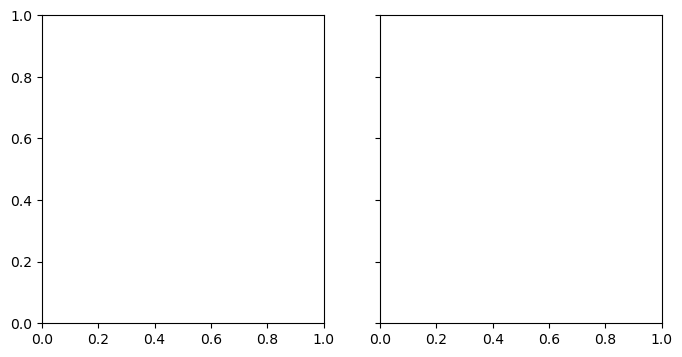

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)  # 1 row, 2 columns

# First subplot
axes[0].plot(latitudes, longitudes - longitudes_ww3)
axes[0].set_xlabel('Latitude [$^\circ$N]')
axes[0].set_ylabel('Longitude difference [$^\circ$E]')
axes[0].set_title('Longitude difference vs Latitude')

# Second subplot
axes[1].plot(longitudes, latitudes - latitudes_ww3)
axes[1].set_xlabel('Longitude [$^\circ$E]')
axes[1].set_ylabel('Latitude difference [$^\circ$N]')
axes[1].set_title('Latitude difference vs Longitude')

plt.tight_layout() 
plt.show()

In [ ]:
x_idk = 130

# Extract latitude
latitudes = -ds_cice['TLAT'].isel(ni=x_idk).compute().values

# Compute the mask: ice exists AND latitude < 0
mask_ice = ((ds_cice['aice'].isel(time=time_idx, ni=x_idk) > 0) & 
            (ds_cice['TLAT'].isel(ni=x_idk) < 0)).compute().values

# Extract wave heights and SIC as NumPy arrays
HS_in_ice = ds_ww3['HS'].isel(time=time_idx, nx=x_idk).compute().values[mask_ice]
wave_ht_in_ice = ds_cice['wave_sig_ht'].isel(time=time_idx, ni=x_idk).compute().values[mask_ice]
aice_in_ice = ds_cice['aice'].isel(time=time_idx, ni=x_idk).compute().values[mask_ice]
ice_in_ice = ds_ww3['ICE'].isel(time=time_idx, nx=x_idk).compute().values[mask_ice]
lat_masked = latitudes[mask_ice]

# Plot
fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis: wave heights
ax1.plot(lat_masked, wave_ht_in_ice, color='blue', label='CICE', linestyle='-')
ax1.plot(lat_masked, HS_in_ice, color='blue', label='WW3', linestyle='--')
ax1.set_ylabel('$H_s$ [m]')
ax1.legend(loc='upper left')

# Right y-axis: SIC (masked)
ax2 = ax1.twinx()
ax2.plot(lat_masked, aice_in_ice, color='lightblue', label='CICE')
ax2.plot(lat_masked, ice_in_ice, color='lightblue', label='WW3', linestyle='--')

ax2.set_ylabel('SIC')
ax2.set_ylim((0,1.1))
ax2.legend(loc='upper right')

ax1.set_yscale('log')

# Add vertical lines only for masked grid cells
for lat in lat_masked:
    ax1.axvline(lat, color='gray', linestyle=':', alpha=0.3)

plt.title(f"Longitude: {np.round(ds_cice['TLON'].isel(ni=x_idk).values.mean())}° E")
ax1.set_xlabel('Latitude [°S]')
plt.show()

### Verify that floe sizes are consistent between models

In [ ]:
x_idk = 110
time_idx = -1

color1 = 'tab:red'
color2 = 'tab:purple'

latitudes = ds_cice['TLAT'].isel(ni=x_idk).values
latitudes_ww3 = ds_ww3['lat'].isel(nx=x_idk).values

fig, ax1 = plt.subplots(figsize=(10,5))

# Left y-axis variables
ax1.plot(latitudes, ds_cice['fsdrad'].isel(time=time_idx, ni=x_idk), color=color1, label='CICE', linestyle='-')
ax1.plot(latitudes_ww3, ds_ww3['ICEF'].isel(time=time_idx, nx=x_idk), color=color1, label='WW3', linestyle='--')
ax1.set_ylabel('Floe size [m]', color=color1)
ax1.legend(loc='upper left')

# Right y-axis for aice
ax2 = ax1.twinx()
ax2.plot(latitudes, ds_cice['hi'].isel(time=time_idx, ni=x_idk), color=color2, label='CICE', linestyle='-')
ax2.plot(latitudes_ww3, ds_ww3['ICEH'].isel(time=time_idx, nx=x_idk), color=color2, label='WW3', linestyle='--')
ax2.set_ylabel('Ice thickness [m]', color=color2)
ax2.legend(loc='upper right')
# ax2.set_ylim((0,1.1))

ax1.set_title('')
ax2.set_title('')
ax1.set_xlabel("Latitude [$^\circ$]")
time_val = pd.Timestamp(ds_cice.time[time_idx].values)
formatted_time = time_val.strftime("%Y-%m-%d %H:%M") 
plt.title(f"Longitude: {np.round(ds_cice['TLON'].isel(ni=x_idk).values.mean())} / {np.round(ds_ww3['lon'].isel(nx=x_idk).values.mean())} E ({formatted_time})")
plt.show()

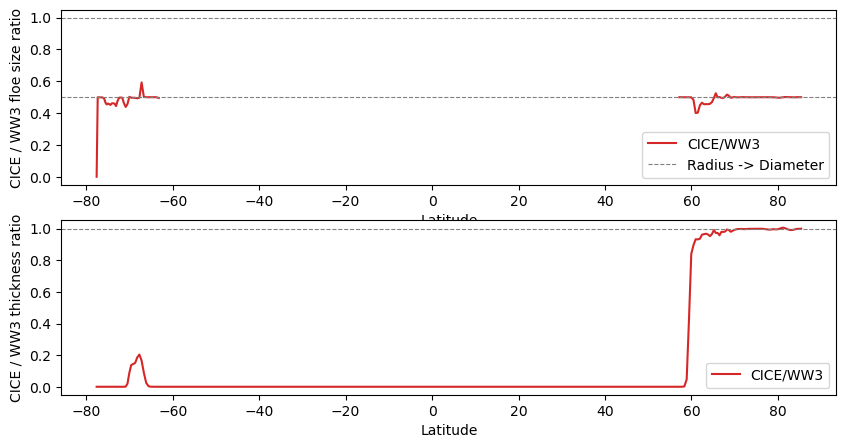

In [27]:
x_idk = 110
time_idx = -1

color1 = 'tab:red'
color2 = 'tab:purple'

latitudes = ds_cice['TLAT'].isel(ni=x_idk).values
latitudes_ww3 = ds_ww3['lat'].isel(nx=x_idk).values

fig, axes = plt.subplots(2, 1, figsize=(10,5))
ax1 = axes[0]
ax2 = axes[1]

# Extract data arrays
cice_vals = ds_cice['fsdrad'].isel(time=time_idx, ni=x_idk).values
ww3_vals = ds_ww3['ICEF'].isel(time=time_idx, nx=x_idk).values

# Interpolate WW3 onto CICE grid
ww3_interp = np.interp(latitudes, latitudes_ww3, ww3_vals)

# Avoid division by zero or invalids
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.where(ww3_interp != 0, cice_vals / ww3_interp, np.nan)

ax1.plot(latitudes, ratio, color=color1, linestyle='-', label='CICE/WW3')
ax1.set_ylabel('CICE / WW3 floe size ratio')
ax1.set_xlabel('Latitude')
ax1.axhline(1, color='gray', linestyle='--', lw=0.8)
ax1.axhline(0.5, color='gray', linestyle='--', lw=0.8, label='Radius -> Diameter')
ax1.legend()

# Extract data arrays
cice_vals = ds_cice['hi'].isel(time=time_idx, ni=x_idk).values
ww3_vals = ds_ww3['ICEH'].isel(time=time_idx, nx=x_idk).values

# Interpolate WW3 onto CICE grid
ww3_interp = np.interp(latitudes, latitudes_ww3, ww3_vals)

# Avoid division by zero or invalids
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.where(ww3_interp != 0, cice_vals / ww3_interp, np.nan)

ax2.plot(latitudes, ratio, color=color1, linestyle='-', label='CICE/WW3')
ax2.set_ylabel('CICE / WW3 thickness ratio')
ax2.set_xlabel('Latitude')
ax2.axhline(1, color='gray', linestyle='--', lw=0.8)
ax2.legend()



plt.show()
# # Right y-axis for aice
# ax2 = ax1.twinx()
# ax2.plot(latitudes, ds_cice['hi'].isel(time=time_idx, ni=x_idk), color=color2, label='CICE', linestyle='-')
# ax2.plot(latitudes_ww3, ds_ww3['ICEH'].isel(time=time_idx, nx=x_idk), color=color2, label='WW3', linestyle='--')
# ax2.set_ylabel('Ice thickness [m]', color=color2)
# ax2.legend(loc='upper right')
# # ax2.set_ylim((0,1.1))

# ax1.set_title('')
# ax2.set_title('')
# ax1.set_xlabel("Latitude [$^\circ$]")
# time_val = pd.Timestamp(ds_cice.time[time_idx].values)
# formatted_time = time_val.strftime("%Y-%m-%d %H:%M") 
# plt.title(f"Longitude: {np.round(ds_cice['TLON'].isel(ni=x_idk).values.mean())} / {np.round(ds_ww3['lon'].isel(nx=x_idk).values.mean())} E ({formatted_time})")
# plt.show()

In [28]:
dsdsds

NameError: name 'dsdsds' is not defined

In [11]:
# # ds.isel(time=-1).plot()
# %matplotlib inline
# # ds
# if hemisphere == "south":
#         projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
#         lat_limits = [-90, -45]
# elif hemisphere == "north":
#     projection = ccrs.NorthPolarStereo(true_scale_latitude=70)
#     lat_limits = [45, 90]
# else:
#     raise ValueError("Invalid hemisphere. Choose 'north' or 'south'.")

# fig, ax = plt.subplots(
#                      subplot_kw={'projection': projection},
#                      gridspec_kw={'wspace': 0.1, 'hspace': 0.15}) 

# ax.set_extent([-180, 180, lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())

# ds.isel(time=-1).plot(
#         ax = ax,
#         x="TLON",
#         y="TLAT",
#         # cmap=settings.get("cmap"),
#         # vmin=settings.get("vmin"),
#         # vmax=settings.get("vmax"),
#         transform=ccrs.PlateCarree(),
#     )
# # plt.show()

## Make a quick movie

In [53]:
from io import BytesIO
import gc
import matplotlib
matplotlib.use("Agg")
import imageio.v3 as iio

plot_settings = {
    "aice": {"cmap": cmo.ice, "vmin": 0, "vmax": 1},
    "fsdrad": {"cmap": cmo.thermal, "vmin": 0, "vmax": 850},
    "hi": {"cmap": cmo.deep, "vmin": 0, "vmax": 5},
    "hs": {"cmap": cmo.amp, "vmin": 0, "vmax": 0.5},
    "hfs": {"cmap": cmo.amp, "vmin": 0, "vmax": 1},
    "tice": {"cmap": cmo.balance, "vmin": -30, "vmax": 0},
    "uvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "vvel": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "strength": {"cmap": cmo.matter, "vmin": 0, "vmax": 50e3},
    "divu": {"cmap": cmo.curl, "vmin": -1e-5, "vmax": 1e-5},
    "shear": {"cmap": cmo.curl, "vmin": 0, "vmax": 1e-5},
    "uocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "vocn": {"cmap": cmo.balance, "vmin": -0.5, "vmax": 0.5},
    "wave_sig_ht": {"cmap": cmo.tempo, "vmin": 0, "vmax": 10},  # Significant wave height
}

# Function to get plot settings for any variable
def get_plot_settings(var_name):
    # Remove common suffixes like "_m" (monthly), "_d" (daily), etc.
    base_var = re.sub(r"_(m|d|h|s|min|max|mean|std)$", "", var_name)
    
    # Check if the cleaned variable exists in settings
    return plot_settings.get(base_var, {"cmap": cmo.gray, "vmin": 0, "vmax": 1})  # Default if not found

def add_ice_contours(ax, ds_plot, hemisphere, projection):

    # if hemisphere=="north":
    transformed_coor=projection.transform_points(ccrs.PlateCarree(),ds_plot['TLON'].values,ds_plot['TLAT'].values)
    x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
    use_transformed_coordinates_directly = True
    # inner_Arctic=xr.where(ds_plot['TLAT']>=81,1,0)
    ### Plot the selected snapshot 
    
    if use_transformed_coordinates_directly:
        cs = ax.contour(x_ster,y_ster,ds_plot['aice'],
                        levels=[0.15, 0.8],linestyles=["-", "--"],colors="magenta",linewidths=0.5
                       )
    else:
        cs = ax.contour(ds_plot['TLON'],ds_plot['TLAT'],ds_plot['aice'],levels=[0.15, 0.8],transform=ccrs.PlateCarree(),
                    linestyles=["-", "--"],colors="magenta",linewidths=0.5)
                
    return cs

def fancier_plot(ds_sel, time, var, hemisphere="south", cleanup=True):
    if hemisphere == "south":
        projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
        lat_limits = [-90, -45]
    elif hemisphere == "north":
        projection = ccrs.NorthPolarStereo(true_scale_latitude=70)
        lat_limits = [45, 90]
    else:
        raise ValueError("Invalid hemisphere. Choose 'north' or 'south'.")

    fig, ax = plt.subplots(
                         subplot_kw={'projection': projection},
                         gridspec_kw={'wspace': 0.1, 'hspace': 0.15})  # Adjust spacing

    # Add coastlines and land features
    ax.add_feature(cft.LAND)
    ax.set_global()
    ax.coastlines(resolution='50m')
    ax.set_extent([-180, 180, lat_limits[0], lat_limits[1]], crs=ccrs.PlateCarree())

    # Get the settings for the selected variable, defaulting to None if not found
    settings = get_plot_settings(var)
    # print(settings.get("cmap"))
    # Apply the settings in the plot call
    ds_sel[var].plot(
        ax=ax,
        x="TLON",
        y="TLAT",
        cmap=settings.get("cmap"),
        vmin=settings.get("vmin"),
        vmax=settings.get("vmax"),
        transform=ccrs.PlateCarree(),
    )
    
    add_ice_contours(ax, ds_sel, hemisphere, projection)
    
    if cleanup:
        with BytesIO() as buf:
            fig.savefig(buf, format="png")
            plt.close(fig)
            image = iio.imread(buf.getvalue())
            
        # Clean up memory
        plt.close(fig)                  # Close the figure explicitly
        del fig, ax, ds_sel, settings   # Delete references to large objects
        gc.collect()                    # Force garbage collection

        return image



In [54]:
# ds_tmp.sel(time=time)


KeyboardInterrupt



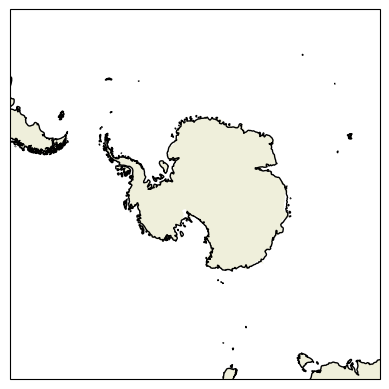

In [65]:
ds_tmp = ds_cice.copy()
%matplotlib inline
var = 'aice'
time = ds_tmp["time"].values[-1]
ds_tmp = ds_tmp.chunk({"time": 1, "ni": -1, "nj": -1})
fancier_plot(ds_tmp.sel(time=time), time, var, hemisphere, cleanup=False)

In [37]:
# ds_tmp = ds_cice.chunk({"time": 1, "ni": -1, "nj": -1})#.isel(time=slice(0,-1,365))


In [60]:
%%time
import calendar
hemisphere = "south"
var = "aice"
# model = "access-om3"
# experiment = "wav_config_iaf"
ds = ds_cice.copy()
ds_tmp = ds.chunk({"time": 1, "ni": -1, "nj": -1}).isel(time=slice(0,-1,50)).copy()

# Add grid to dataset
ds_tmp['TLON'] = np.degrees(grid_ds['tlon'])
ds_tmp['TLAT'] = np.degrees(grid_ds['tlat'])

nj_len = len(ds_tmp.nj)
half_nj_len = int(np.ceil(nj_len/2))
if hemisphere == "south":
    ds_tmp = ds.isel(nj=slice(0, half_nj_len))
elif hemisphere == "north":
    ds_tmp = ds.isel(nj=slice(half_nj_len, -1))
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds



futures = [
    client.submit(fancier_plot, ds_tmp.sel(time=time), time, var, hemisphere) for time in ds_tmp["time"].values
]

num_frames = len(futures)
duration = 20
duration_per_frame = duration / num_frames  # 5 seconds total

with iio.imopen(f"/home/566/nd0349/access-om3-analysis/figures/{var}_{model}_{experiment}_{hemisphere}.gif", 
                "w", extension=".gif") as f:
    for future in futures:
        image = future.result()
        f.write(image, duration=duration_per_frame)



The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


2025-11-14 10:31:06,499 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('fancier_plot-bd1033d696b22a2e4513f17c5039e9c7')" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-11-14 10:31:06,499 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('fancier_plot-6dd4ada3f9350e79bd3efe5481b4304c')" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker_state_machine.py:3607>> ended with CancelledError
2025-11-14 10:31:06,500 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute('fancier_plot-951b2bd3b3b355c5708a837b5c4b7061')" coro=<Worker.execute() done, defined at /g/data/xp65/public/apps/med_conda/envs/analysis3-25.

KeyboardInterrupt: 

In [57]:
# ds_tmp

In [ ]:
%matplotlib inline
time = ds.isel(time=-1).time
var = "fsdrad"
fancier_plot(ds.isel(time=0)[var], time, var, cleanup=False)
plt.show()

In [ ]:
ds.isel(time=-1)['aice'].plot()

## SIE and SIA

In [81]:
OBS_TIME_SLICE = slice("1979", "2022")
sh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4shmday"
nh_obs_url = "https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday"


def open_cdr_dataset(path, area_file):
    ds = xr.open_dataset(path).rename(
        {'cdr_seaice_conc_monthly': 'cdr_conc', 'xgrid':'x','ygrid':'y'}
    )

    # # we also need the area of each gridcell
    areasNd = np.fromfile(area_file, dtype=np.int32).reshape(
        ds.cdr_conc.isel(time=0).shape
    )
    # # Divide by 1000 to get km2 (https://web.archive.org/web/20170817210544/http://nsidc.org/data/polar-stereo/tools_geo_pixel.html#pixel_area)
    areasKmNd_sh = areasNd / 1000
        
    ds["area"] = xr.DataArray(areasKmNd_sh, dims=["y", "x"])
    ds = ds.set_coords("area")

    ds["cdr_conc"] = ds.cdr_conc.where(ds.cdr_conc<=1)  # convert error codes to Nan

    return ds

!wget --ftp-user=anonymous -nc ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/pss25area_v3.dat ftp://sidads.colorado.edu/DATASETS/seaice/polar-stereo/tools/psn25area_v3.dat

sh_cdr_xr = open_cdr_dataset(sh_obs_url, "pss25area_v3.dat")

nh_cdr_xr = open_cdr_dataset(
    nh_obs_url,
    'psn25area_v3.dat'
)

cdr_dt = DataTree.from_dict(
    {
        "cdr_sh": sh_cdr_xr,
        'cdr_nh':nh_cdr_xr
    }
)

File ‘pss25area_v3.dat’ already there; not retrieving.
File ‘psn25area_v3.dat’ already there; not retrieving.


In [47]:
def sea_ice_area(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["x", "y"])
    
def sea_ice_area_model(sic, area, range=[0.15, 1]):
    return (sic * area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

def sea_ice_extent(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).cf.sum(["x", "y"])

def sea_ice_extent_model(sic, area, range=[0.15, 1]):
    return (area).where((sic >= range[0]) * (sic <= range[1])).sum(["ni", "nj"])

In [48]:
def sea_ice_area_obs(ds):

    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    
    sic = ds.cdr_conc
    result = sea_ice_area(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    return result.sel(time=OBS_TIME_SLICE)
obs_area_dt = cdr_dt.map_over_datasets(sea_ice_area_obs)

In [82]:
def sea_ice_extent_obs(ds):

    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    
    sic = ds.cdr_conc
    result = sea_ice_extent(sic, sic.area).to_dataset(name="cdr_area")

    # Theres a couple of data gaps which should be nan
    result.loc[{"time": "1988-01-01"}] = np.nan
    result.loc[{"time": "1987-12"}] = np.nan

    return result.sel(time=OBS_TIME_SLICE)

In [90]:
obs_area_dt = sea_ice_area_obs(cdr_dt)
obs_si_area = (cdr_dt['cdr_sh']['cdr_conc'] * cdr_dt['cdr_sh']['cdr_conc'].area).sum(dim=["x", "y"]) 
obs_si_extent = (cdr_dt['cdr_sh']['cdr_conc'].area).where((cdr_dt['cdr_sh']['cdr_conc'] >= 0.15) * (cdr_dt['cdr_sh']['cdr_conc'] <= 1.0)).sum(dim=["x", "y"]) 
obs_si_extent_nh = (cdr_dt['cdr_nh']['cdr_conc'].area).where((cdr_dt['cdr_nh']['cdr_conc'] >= 0.15) * (cdr_dt['cdr_nh']['cdr_conc'] <= 1.0)).sum(dim=["x", "y"]) 

In [91]:
cdr_dt

<xarray.DataTree>
Group: /
├── Group: /cdr_sh
│       Dimensions:                           (time: 554, y: 332, x: 316)
│       Coordinates:
│         * time                              (time) datetime64[ns] 4kB 1978-11-01 .....
│         * y                                 (y) float32 1kB 4.338e+06 ... -3.938e+06
│         * x                                 (x) float32 1kB -3.938e+06 ... 3.938e+06
│           area                              (y, x) float64 839kB 444.1 445.0 ... 460.1
│       Data variables:
│           cdr_conc                          (time, y, x) float32 232MB 0.0 0.0 ... 0.0
│           nsidc_bt_seaice_conc_monthly      (time, y, x) float32 232MB ...
│           nsidc_nt_seaice_conc_monthly      (time, y, x) float32 232MB ...
│           qa_of_cdr_seaice_conc_monthly     (time, y, x) float32 232MB ...
│           stdev_of_cdr_seaice_conc_monthly  (time, y, x) float32 232MB ...
│       Attributes: (12/66)
│           _NCProperties:                                       version=2,netcdf=4.8...
│           acknowledgement:                                     This project was sup...
│           cdm_data_type:                                       Grid
│           cdr_variable:                                        cdr_seaice_conc_monthly
│           contributor_name:                                    Walter N. Meier, Flo...
│           contributor_role:                                    principal investigat...
│           ...                                                  ...
│           summary:                                             This data set provid...
│           time_coverage_duration:                              P1M
│           time_coverage_end:                                   2024-12-01T00:00:00Z
│           time_coverage_resolution:                            P1M
│           time_coverage_start:                                 1978-11-01T00:00:00Z
│           title:                                               Sea Ice Concentratio...
└── Group: /cdr_nh
        Dimensions:                                 (time: 554, y: 448, x: 304)
        Coordinates:
          * time                                    (time) datetime64[ns] 4kB 1978-11...
          * y                                       (y) float32 2kB 5.838e+06 ... -5....
          * x                                       (x) float32 1kB -3.838e+06 ... 3....
            area                                    (y, x) float64 1MB 382.7 ... 407.9
        Data variables:
            cdr_conc                                (time, y, x) float32 302MB 0.0 .....
            melt_onset_day_cdr_seaice_conc_monthly  (time, y, x) float32 302MB ...
            nsidc_bt_seaice_conc_monthly            (time, y, x) float32 302MB ...
            nsidc_nt_seaice_conc_monthly            (time, y, x) float32 302MB ...
            qa_of_cdr_seaice_conc_monthly           (time, y, x) float32 302MB ...
            stdev_of_cdr_seaice_conc_monthly        (time, y, x) float32 302MB ...
        Attributes: (12/66)
            _NCProperties:                                       version=2,netcdf=4.8...
            acknowledgement:                                     This project was sup...
            cdm_data_type:                                       Grid
            cdr_variable:                                        cdr_seaice_conc_monthly
            comment:                                             The variable melt_on...
            contributor_name:                                    Walter N. Meier, Flo...
            ...                                                  ...
            summary:                                             This data set provid...
            time_coverage_duration:                              P1M
            time_coverage_end:                                   2024-12-01T00:00:00Z
            time_coverage_resolution:                            P1M
            time_coverage_start:                           

In [92]:
ds_sia = sea_ice_area_model(ds_cice['aice'], ds_cice.tarea).compute()
ds_sia

<xarray.DataArray (time: 699)> Size: 6kB
array([1.21999355e+13, 1.32976634e+13, 1.35257123e+13, 1.36432948e+13,
       1.36880952e+13, 1.36914690e+13, 1.36459804e+13, 1.35781615e+13,
       1.35555252e+13, 1.35855372e+13, 1.36181499e+13, 1.36955424e+13,
       1.37301684e+13, 1.37407552e+13, 1.37439744e+13, 1.37247674e+13,
       1.37147867e+13, 1.36755286e+13, 1.36473851e+13, 1.36027177e+13,
       1.35082278e+13, 1.34548953e+13, 1.34152839e+13, 1.33932206e+13,
       1.33621544e+13, 1.33672262e+13, 1.33670933e+13, 1.33395779e+13,
       1.32604408e+13, 1.32031701e+13, 1.32048398e+13, 1.32459232e+13,
       1.32954981e+13, 1.32944229e+13, 1.32666753e+13, 1.32519337e+13,
       1.32327582e+13, 1.32155742e+13, 1.32520127e+13, 1.33209613e+13,
       1.33781615e+13, 1.34158903e+13, 1.34473075e+13, 1.34488856e+13,
       1.34340139e+13, 1.34473319e+13, 1.34269092e+13, 1.33410092e+13,
       1.33001680e+13, 1.33097361e+13, 1.33293629e+13, 1.34191376e+13,
       1.35351495e+13, 1.36045955e+13, 1.36397676e+13, 1.36557824e+13,
       1.36494123e+13, 1.36102772e+13, 1.35840907e+13, 1.35732577e+13,
       1.35737378e+13, 1.35364800e+13, 1.34728395e+13, 1.34290918e+13,
       1.34030449e+13, 1.33671153e+13, 1.33924487e+13, 1.34083594e+13,
       1.34185145e+13, 1.34227028e+13, 1.34059284e+13, 1.34128538e+13,
       1.34139651e+13, 1.34273425e+13, 1.34475726e+13, 1.34797415e+13,
       1.35218727e+13, 1.35685376e+13, 1.35967982e+13, 1.36174039e+13,
...
       7.65582915e+12, 7.67483991e+12, 7.67020058e+12, 7.68369901e+12,
       7.71963040e+12, 7.74373703e+12, 7.73514147e+12, 7.75376277e+12,
       7.78465039e+12, 7.82152125e+12, 7.88574048e+12, 7.99144195e+12,
       8.09293258e+12, 8.15014005e+12, 8.19871715e+12, 8.28276488e+12,
       8.37613532e+12, 8.45466338e+12, 8.53004320e+12, 8.58500645e+12,
       8.61352972e+12, 8.65687814e+12, 8.70256643e+12, 8.76168144e+12,
       8.82066517e+12, 8.86572049e+12, 8.92431192e+12, 9.00266427e+12,
       9.06463436e+12, 9.11726097e+12, 9.21900769e+12, 9.41478650e+12,
       9.66852319e+12, 9.84387586e+12, 9.96437813e+12, 1.00239159e+13,
       1.01150632e+13, 1.02920429e+13, 1.04542423e+13, 1.05970534e+13,
       1.07069693e+13, 1.07809075e+13, 1.08656408e+13, 1.09259939e+13,
       1.09434986e+13, 1.09511147e+13, 1.09518556e+13, 1.09818689e+13,
       1.10472180e+13, 1.11079364e+13, 1.11637660e+13, 1.12126444e+13,
       1.12300745e+13, 1.12223347e+13, 1.12123164e+13, 1.12298069e+13,
       1.12655266e+13, 1.12813366e+13, 1.12942131e+13, 1.12991246e+13,
       1.12802639e+13, 1.12386634e+13, 1.12457534e+13, 1.12900908e+13,
       1.13156885e+13, 1.12927534e+13, 1.12486515e+13, 1.12004532e+13,
       1.11662683e+13, 1.11701358e+13, 1.12044564e+13, 1.12052893e+13,
       1.12241785e+13, 1.12487631e+13, 1.12533688e+13, 1.12285192e+13,
       1.12228754e+13, 1.12768452e+13, 1.13561200e+13])
Coordinates:
  * time     (time) object 6kB 1900-01-01 00:00:00 ... 1901-11-30 00:00:00

In [93]:
# @map_over_subtree
def calculate_SIA_SIE_model(ds):
    # Compute for Southern Hemisphere
    sic_south = ds.aice.where(ds.TLAT < 0)
    area_south_km2 = grid_ds.tarea.where(ds.TLAT < 0) / 1e6
    si_area_south = sea_ice_area_model(sic_south, area_south_km2).to_dataset(name="si_area_south")
    si_extent_south = sea_ice_extent_model(sic_south, area_south_km2).to_dataset(name="si_extent_south")

    # Compute for Northern Hemisphere
    sic_north = ds.aice.where(ds.TLAT > 0)
    area_north_km2 = grid_ds.tarea.where(ds.TLAT > 0) / 1e6
    si_area_north = sea_ice_area_model(sic_north, area_north_km2).to_dataset(name="si_area_north")
    si_extent_north = sea_ice_extent_model(sic_north, area_north_km2).to_dataset(name="si_extent_north")

    # Merge both hemispheres into a single dataset
    return xr.merge([si_area_south, si_extent_south, si_area_north, si_extent_north]).load()


In [94]:
model_SIA_SIE_dt = calculate_SIA_SIE_model(ds_cice)
# model_SIA_SIE_dt = calculate_SIA_SIE_model(ds_cice.isel(time=slice(10*365,20*365)))
# model_SIA_SIE_dt_FY['si_extent_north']
model_SIA_SIE_dt

<xarray.Dataset> Size: 28kB
Dimensions:          (time: 699)
Coordinates:
  * time             (time) object 6kB 1900-01-01 00:00:00 ... 1901-11-30 00:...
Data variables:
    si_area_south    (time) float64 6kB 1.916e+06 1.89e+06 ... 1.014e+06
    si_extent_south  (time) float64 6kB 2.041e+06 2.142e+06 ... 1.636e+06
    si_area_north    (time) float64 6kB 1.028e+07 1.141e+07 ... 1.034e+07
    si_extent_north  (time) float64 6kB 1.176e+07 1.214e+07 ... 1.077e+07

Text(0, 0.5, 'SIE [km$^2$]')

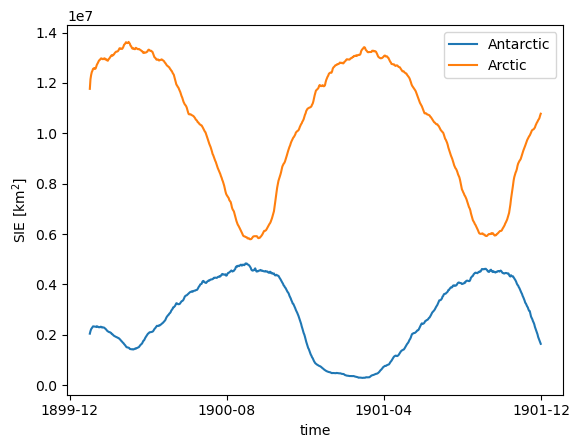

In [99]:
model_SIA_SIE_dt['si_extent_south'].plot(label='Antarctic')
model_SIA_SIE_dt['si_extent_north'].plot(label='Arctic')
plt.legend()
plt.ylabel("SIE [km$^2$]")

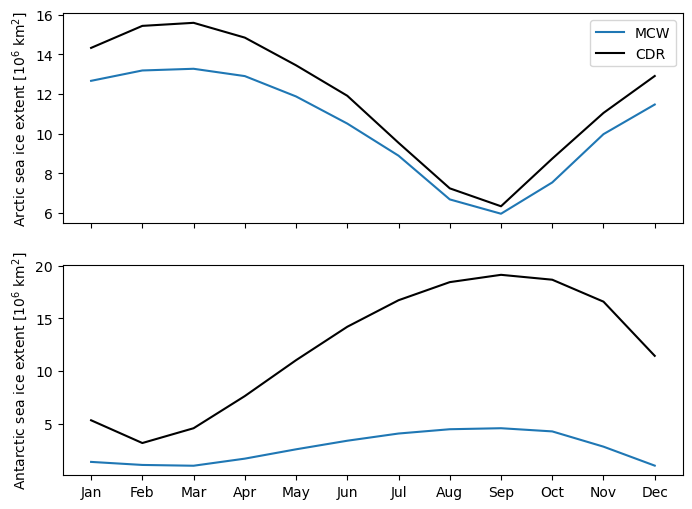

In [96]:
%matplotlib inline
import seaborn as sns
import calendar

cmap = sns.color_palette(n_colors=5)
linewidth = 0.5

fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

# Arctic
# (model_SIA_SIE_dt['si_extent_north'].groupby("time.month").mean()  * 1e-6).plot(ax=axes[0], label="First year", color='gray')
grouped = model_SIA_SIE_dt['si_extent_north'].groupby("time.month")
mean = grouped.mean() * 1e-6
std = grouped.std() * 1e-6
mean.plot(ax=axes[0], label="MCW")
# axes[0].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
(obs_si_extent_nh.groupby("time.month").mean() * 1e-6).plot(ax=axes[0], label="CDR", color='k')

# Antarctic
# (model_SIA_SIE_dt['si_extent_south'].groupby("time.month").mean()  * 1e-6).plot(ax=axes[1], label="First year", color='gray')
grouped = model_SIA_SIE_dt['si_extent_south'].groupby("time.month")
mean = grouped.mean() * 1e-6
std = grouped.std() * 1e-6
mean.plot(ax=axes[1], label="Mean")
# axes[1].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
(obs_si_extent.groupby("time.month").mean() * 1e-6).plot(ax=axes[1], label="CDR", color='k')

# Labels
axes[0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
axes[1].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

axes[0].legend()

for ax in axes:
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/{experiment}/SIE_{experiment}.png", dpi=600, bbox_inches="tight") 
plt.show()

NameError: name 'model_SIA_SIE_dt_FY' is not defined

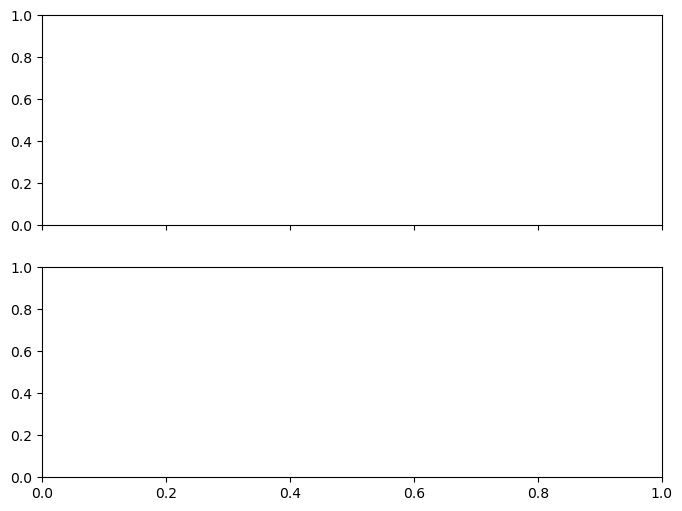

In [67]:
%matplotlib inline
import seaborn as sns
import calendar

cmap = sns.color_palette(n_colors=5)
linewidth = 0.5

fig, axes = plt.subplots(nrows=2, figsize=(8, 6), sharex=True)

# Arctic
(model_SIA_SIE_dt_FY['si_extent_north']  * 1e-6).plot(ax=axes[0], label="First year", color='gray')
# grouped = model_SIA_SIE_dt['si_extent_north']
# mean = grouped.mean() * 1e-6
# std = grouped.std() * 1e-6
# mean.plot(ax=axes[0], label="Mean after 10 year spinup")
# axes[0].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
# (obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[0], label="CDR", color='k')

# Antarctic
(model_SIA_SIE_dt_FY['si_extent_south'] * 1e-6).plot(ax=axes[1], label="First year", color='gray')
# grouped = model_SIA_SIE_dt['si_extent_south'].groupby("time.month")
# mean = grouped.mean() * 1e-6
# std = grouped.std() * 1e-6
# mean.plot(ax=axes[1], label="Mean")
# axes[1].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
# (obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[1], label="CDR", color='k')

# Labels
axes[0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
axes[1].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

axes[0].legend()

for ax in axes:
    # ax.set_xticks(range(1, 13))
    # ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/{experiment}/SIE_{experiment}.png", dpi=600, bbox_inches="tight") 
plt.show()

In [48]:

def sea_ice_area_model_sh(ds):
    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds
    ds = ds.sel(nj=slice(0,150))
    sic = ds.aice
    area_km2 = ds.tarea / 1e6

    return sea_ice_area_model(sic, area_km2).to_dataset(name="si_area").load()

model_area_dt = sea_ice_area_model_sh(ds_cice)

In [52]:
model_area_dt

<xarray.Dataset> Size: 24kB
Dimensions:  (time: 1492)
Coordinates:
  * time     (time) datetime64[ns] 12kB 1958-01-01 1958-01-02 ... 1962-01-31
Data variables:
    si_area  (time) float64 12kB 1.101e+08 1.086e+08 ... 4.134e+07 3.993e+07

## Calculate sea ice trends

In [53]:
def min_and_max_year(da):
    result = xr.Dataset()
    result["min"] = da.min()
    result["max"] = da.max()
    return result

def min_and_max(ds):
    # root dataset in datatree is not used
    if ds is None or 'time' not in ds:
        return ds

    annual_min_max_ds = ds.si_area.groupby("time.year").apply(min_and_max_year)
    return annual_min_max_ds

# model_min_max_dt = model_area_dt.map_over_datasets(min_and_max)
model_min_max_dt = min_and_max(model_area_dt)

In [56]:
obs_area_dt["cdr_sh"].ds#.groupby("time.year").min()

<xarray.DatasetView> Size: 1GB
Dimensions:                           (time: 554, y: 332, x: 316)
Coordinates:
  * time                              (time) datetime64[ns] 4kB 1978-11-01 .....
  * y                                 (y) float32 1kB 4.338e+06 ... -3.938e+06
  * x                                 (x) float32 1kB -3.938e+06 ... 3.938e+06
    area                              (y, x) float64 839kB 444.1 445.0 ... 460.1
Data variables:
    cdr_conc                          (time, y, x) float32 232MB 0.0 0.0 ... 0.0
    nsidc_bt_seaice_conc_monthly      (time, y, x) float32 232MB ...
    nsidc_nt_seaice_conc_monthly      (time, y, x) float32 232MB ...
    qa_of_cdr_seaice_conc_monthly     (time, y, x) float32 232MB ...
    stdev_of_cdr_seaice_conc_monthly  (time, y, x) float32 232MB ...
Attributes: (12/66)
    _NCProperties:                                       version=2,netcdf=4.8...
    acknowledgement:                                     This project was sup...
    cdm_data_type:                                       Grid
    cdr_variable:                                        cdr_seaice_conc_monthly
    contributor_name:                                    Walter N. Meier, Flo...
    contributor_role:                                    principal investigat...
    ...                                                  ...
    summary:                                             This data set provid...
    time_coverage_duration:                              P1M
    time_coverage_end:                                   2024-12-01T00:00:00Z
    time_coverage_resolution:                            P1M
    time_coverage_start:                                 1978-11-01T00:00:00Z
    title:                                               Sea Ice Concentratio...

<xarray.DataTree 'cdr_sh'>
Group: /cdr_sh
    Dimensions:                           (time: 554, y: 332, x: 316)
    Coordinates:
      * time                              (time) datetime64[ns] 4kB 1978-11-01 .....
      * y                                 (y) float32 1kB 4.338e+06 ... -3.938e+06
      * x                                 (x) float32 1kB -3.938e+06 ... 3.938e+06
        area                              (y, x) float64 839kB 444.1 445.0 ... 460.1
    Data variables:
        cdr_conc                          (time, y, x) float32 232MB 0.0 0.0 ... 0.0
        nsidc_bt_seaice_conc_monthly      (time, y, x) float32 232MB ...
        nsidc_nt_seaice_conc_monthly      (time, y, x) float32 232MB ...
        qa_of_cdr_seaice_conc_monthly     (time, y, x) float32 232MB ...
        stdev_of_cdr_seaice_conc_monthly  (time, y, x) float32 232MB ...
    Attributes: (12/66)
        _NCProperties:                                       version=2,netcdf=4.8...
        acknowledgement:                                     This project was sup...
        cdm_data_type:                                       Grid
        cdr_variable:                                        cdr_seaice_conc_monthly
        contributor_name:                                    Walter N. Meier, Flo...
        contributor_role:                                    principal investigat...
        ...                                                  ...
        summary:                                             This data set provid...
        time_coverage_duration:                              P1M
        time_coverage_end:                                   2024-12-01T00:00:00Z
        time_coverage_resolution:                            P1M
        time_coverage_start:                                 1978-11-01T00:00:00Z
        title:                                               Sea Ice Concentratio...

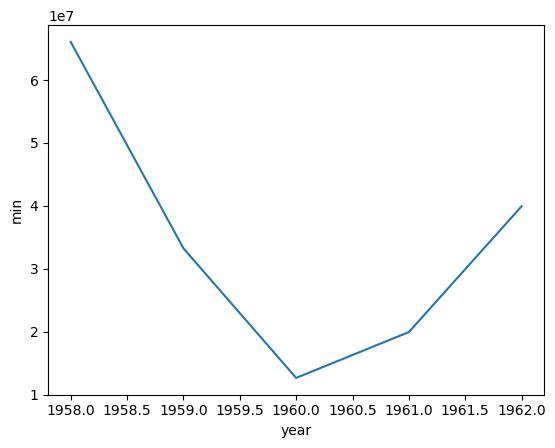

In [59]:
model_min_max_dt["min"].plot(label=experiment)
obs_area_dt["cdr_sh"]

KeyboardInterrupt: 

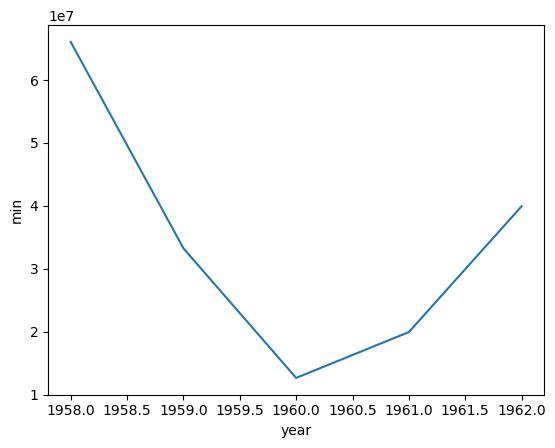

In [55]:
# for group in model_min_max_dt.groups[1:]:
    # ds = model_min_max_dt[group].ds
model_min_max_dt["min"].plot(label=experiment)

obs_area_dt["cdr_sh"].ds.groupby("time.year").min().plot(label="CDR")

plt.title("Trends in Sea-Ice Minima")
plt.ylabel("Sea-Ice Area ($km^2$)")

_ = plt.legend()

In [ ]:
obs_area_dt

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Southern Hemisphere subplot
ax = axes[0]

    
if len(model_min_max_nh_dt["min"]) == 1:
    ax.scatter(model_min_max_nh_dt["min"].coords["year"], model_min_max_nh_dt["min"].values, label=iGroup[1:])
else:
    model_min_max_nh_dt["min"].plot(ax=ax, label=experiment)
axes[0].set_title("Arctic")
# obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')


ax = axes[1]
if len(model_min_max_sh_dt["min"]) == 1:
    ax.scatter(model_min_max_sh_dt["min"].coords["year"], model_min_max_sh_dt["min"].values, label=iGroup[1:])
else:
    model_min_max_sh_dt["min"].plot(ax=ax, label=experiment)
# obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')
axes[1].set_title("Antarctic")
# ax.set_ylabel("Sea Ice Area [km$^2$]")
# ax.set_title("Northern Hemisphere Sea Ice Minima")
# ax.legend()

plt.tight_layout()
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_min_subplot_{experiment}.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Southern Hemisphere subplot
ax = axes[0]

    
if len(model_min_max_nh_dt["max"]) == 1:
    ax.scatter(model_min_max_nh_dt["max"].coords["year"], model_min_max_nh_dt["max"].values, label=iGroup[1:])
else:
    model_min_max_nh_dt["max"].plot(ax=ax, label=experiment)

axes[0].set_title("Arctic")
# obs_area_dt["cdr_nh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')


ax = axes[1]
if len(model_min_max_sh_dt["max"]) == 1:
    ax.scatter(model_min_max_sh_dt["min"].coords["year"], model_min_max_sh_dt["max"].values, label=iGroup[1:])
else:
    model_min_max_sh_dt["max"].plot(ax=ax, label=experiment)
axes[1].set_title("Antarctic")
# obs_area_dt["cdr_sh"].ds.cdr_area.groupby("time.year").min().plot(ax=ax, label="CDR", color='k')

# ax.set_ylabel("Sea Ice Area [km$^2$]")
# ax.set_title("Northern Hemisphere Sea Ice Minima")
# ax.legend()

plt.tight_layout()
plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/climatology_sea_ice_area_max_subplot_{experiment}.png", dpi=300, bbox_inches="tight")
plt.show()

## Compare two runs

In [12]:
import intake
experiment1 = "mom6-cice6_ryf_rel_wav"
experiment2 = "wav_iaf_rel"
model = "access-om3"

esm_datastore1 = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{experiment1}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ],
)
esm_datastore2 = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{experiment2}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ],
)

In [13]:
esm_datastore_filtered1 = esm_datastore1.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], #require_all_on="path"
)
esm_datastore_filtered1

In [14]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
var = 'aice'
ds1 = esm_datastore_filtered1.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]

grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds1['TLON'] = np.degrees(grid_ds['tlon'])
ds1['TLAT'] = np.degrees(grid_ds['tlat'])
ds1

CPU times: user 3.77 s, sys: 557 ms, total: 4.33 s
Wall time: 5.96 s


<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [15]:
esm_datastore_filtered2 = esm_datastore2.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], require_all_on="path"
)
esm_datastore_filtered2

In [16]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
var = 'aice'
ds2 = esm_datastore_filtered2.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]
# Add grid to dataset
ds2['TLON'] = np.degrees(grid_ds['tlon'])
ds2['TLAT'] = np.degrees(grid_ds['tlat'])
ds2

CPU times: user 366 ms, sys: 84.5 ms, total: 450 ms
Wall time: 664 ms


<xarray.Dataset> Size: 102MB
Dimensions:      (time: 28, nj: 300, ni: 360)
Coordinates:
  * time         (time) datetime64[ns] 224B 1958-01-01T12:00:00 ... 1958-01-2...
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  This year has 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,time: mean,time: mea...
    intake_esm_attrs:variable_units:          days since 1958-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_XXXX_XX_XX.1day

In [17]:
# var = "aice"

# esm_datastore_filtered = esm_datastore.search(
#     variable=["aice_m", "fsdrad_m", "wave_sig_ht_m"], frequency="1mon", require_all_on="path"
# )
ds1

<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

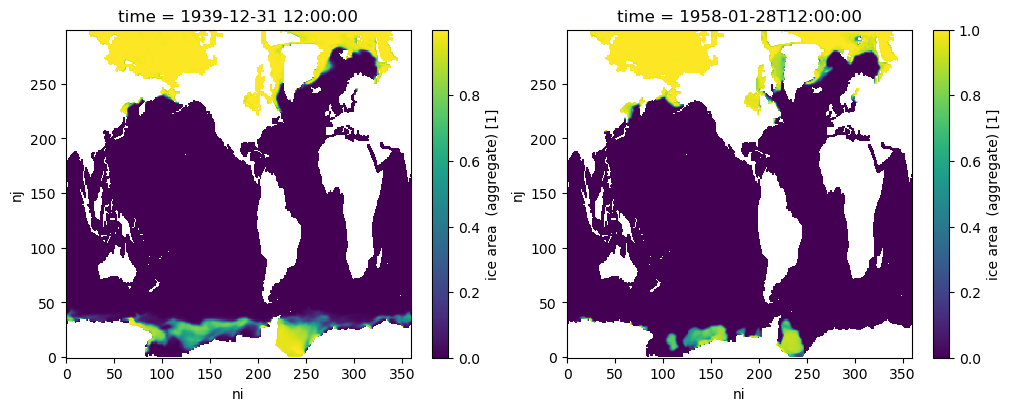

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

ds1['aice'].isel(time=-1).plot(ax=axes[0])
ds2['aice'].isel(time=-1).plot(ax=axes[1])

plt.show()

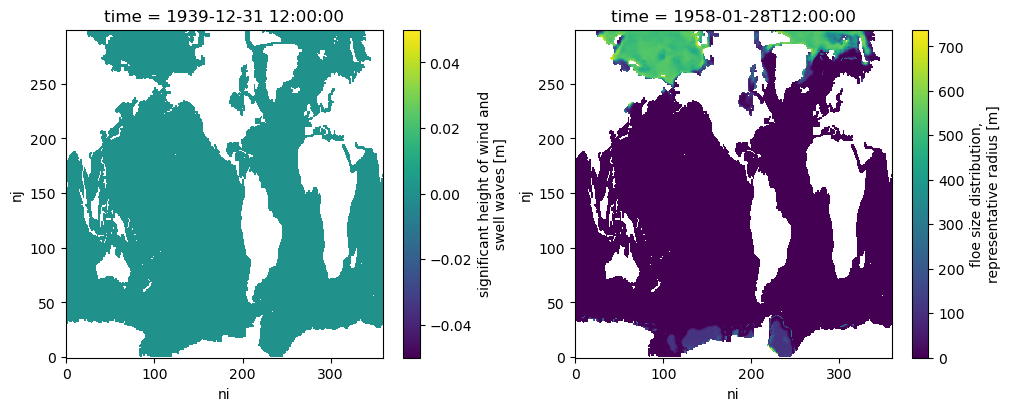

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), constrained_layout=True)

ds1['wave_sig_ht'].isel(time=-1).plot(ax=axes[0])
ds2['fsdrad'].isel(time=-1).plot(ax=axes[1])

plt.show()

In [20]:
%matplotlib inline
def basic_axis(dims, hemisphere="south"):
    if hemisphere=="south":
        projection = ccrs.SouthPolarStereo(true_scale_latitude=-70)
        extent = [-180, 180, -90, -45]
    else:
        # projection = ccrs.NorthPolarStereo(true_scale_latitude=90)
        extent = [-180, 180, 60, 90]
        projection = ccrs.Stereographic(
            central_latitude=90.0,
            central_longitude=-45.0,
            true_scale_latitude=60.0,
            globe=ccrs.Globe(semimajor_axis=6378273.0, semiminor_axis=6356889.448910593)
            )
        
    # Determine number of rows and columns for subplots
    ncols = dims[1]#int(np.ceil(np.sqrt(number_panels)))
    nrows = dims[0]#int(np.ceil(number_panels / ncols))
    number_panels = ncols*nrows
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        subplot_kw={'projection': projection},
        figsize=(4 * ncols, 4 * nrows),  # Adjust figure size
        gridspec_kw={'wspace': 0.15, 'hspace': 0.15}  # Adjust spacing
    )
    
    if number_panels == 1:
        axes = np.array([[axes]])  # Ensure axes is always a 2D array
    elif nrows == 1 or ncols == 1:
        axes = axes.reshape((nrows, ncols))
    
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='none',
                                        facecolor='gray', linewidth=0.5)
    
    for ax in axes.flat[:number_panels]:  # Only iterate over required axes
        ax.set_global()
        ax.coastlines(resolution='50m')
        ax.add_feature(land_50m)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Hide unused subplots if necessary
    for ax in axes.flat[number_panels:]:
        ax.set_visible(False)
    axes = axes.flatten()
    return fig, axes, projection

def add_ice_contours(ax, ds_plot, hemisphere, projection):

    # if hemisphere=="north":
    transformed_coor=projection.transform_points(ccrs.PlateCarree(),ds_plot['TLON'].values,ds_plot['TLAT'].values)
    x_ster,y_ster=transformed_coor[:,:,0],transformed_coor[:,:,1]
    use_transformed_coordinates_directly = True
    # inner_Arctic=xr.where(ds_plot['TLAT']>=81,1,0)
    ### Plot the selected snapshot 
    
    if use_transformed_coordinates_directly:
        cs = ax.contour(x_ster,y_ster,ds_plot['aice'],levels=[0.15, 0.8],linestyles=["-", "--"],colors="magenta",linewidths=0.5)
    else:
        cs = ax.contour(ds_plot['TLON'],ds_plot['TLAT'],ds_plot['aice'],levels=[0.15, 0.8],transform=ccrs.PlateCarree(),
                    linestyles=["-", "--"],colors="magenta",linewidths=0.5)
                
    # else:

    #     cs = ax.contour(
    #         ds_plot["TLON"], ds_plot["TLAT"], ds_plot["aice"],
    #         levels=[0.15, 0.8], linestyles=["-", "--"], colors="magenta", linewidths=1, transform=ccrs.PlateCarree()
    #     )
    return cs

In [21]:
ds1

<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [22]:
import socket

def get_path(experiments):
    hostname = socket.gethostname()
    if "gadi" in hostname:
        machine = "gadi"
        #path = "/g/data/ps29/nd0349/runs/cice6/"
        path = "/scratch/ps29/nd0349/CICE_RUNS/"
        fig_path = "/home/566/nd0349/access-om3-analysis/figures/"
    elif "setonix" in hostname:
        machine = "setonix"
    else:
        machine = "noahday"
        path = "/Users/noahday/GitHub/cice-dev/cice-dirs/runs/"
        fig_path = "/Users/noahday/GitHub/access-om3-analysis/figures/"

    print(f"Running on {machine}")
        
    return path, fig_path


experiment_sets = {
    "test": ["sandbox"], #["baseline-1deg", "nofsd-1deg", "wave-profile-1deg"], # "sandbox", "test"
    "gx3": ["baseline-gx3", "wave-constant-gx3", "wave-profile-gx3", "wave-random-gx3"],
    "baseline": ["baseline-1deg", "baseline-025deg"],
    "wave-1deg": ["nofsd-1deg"], # "wave-profile-1deg", "wave-random-1deg" , "nofsd-1deg"
    "temp": ["baseline-1deg", "wave-profile-1deg", "wave-propagation-1deg"],
}
experiment = "wave-propagation-1deg"
experiment_path, fig_path = get_path(experiment)

histfreq = "d"
path = os.path.join(experiment_path, experiment, "history/")
if histfreq == "h":
    file_pattern = os.path.join(path, "iceh_01h.????-??-??-?????.nc")
    time_delta = timedelta(minutes=30)
elif histfreq == "d":
    file_pattern = os.path.join(path, "iceh.????-??-??.nc")
    time_delta = timedelta(hours=12)
elif histfreq == "m":
    file_pattern = os.path.join(path, "iceh.????-??.nc")  # Adjust this if needed
    time_delta = timedelta(days=16)
files = sorted(glob.glob(file_pattern))

basic_ice_vars = ["aice", "hi", "iage", "fsdrad"]
ocn_forcing_vars = ["sst", "sss", "uocn", "vocn"]
wave_forcing_vars = ["wave_sig_ht"] # peak period? MWD?

VARS = basic_ice_vars + ocn_forcing_vars + wave_forcing_vars
VARS_with_m = VARS + [var + "_m" for var in VARS]
VARS = VARS + VARS_with_m
keep_vars = ["TLAT", "TLON", "time", "tarea", "NFSD", "NCAT"] + VARS

sample_ds = xr.open_dataset(files[0])
drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
    
ds0 = xr.open_mfdataset(
        files,
        combine="by_coords",
        use_cftime=True,      # ensures all times use cftime objects
        drop_variables=drop_vars,
        decode_times=True,
    )


ds0

Running on gadi


<xarray.Dataset> Size: 787MB
Dimensions:      (time: 364, nc: 5, nf: 12, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 3kB 1958-01-02 00:00:00 ... 1958-12-31 00:00:00
    TLON         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    TLAT         (nj, ni) float32 432kB dask.array<chunksize=(300, 360), meta=np.ndarray>
Dimensions without coordinates: nc, nf, nj, ni
Data variables:
    NCAT         (time, nc) float32 7kB dask.array<chunksize=(1, 5), meta=np.ndarray>
    NFSD         (time, nf) float32 17kB dask.array<chunksize=(1, 12), meta=np.ndarray>
    tarea        (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    hi           (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float32 157MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    title:               sea ice model output for CICE
    contents:            Diagnostic and Prognostic Variables
    source:              Los Alamos Sea Ice Model, CICE_6.6.0
    comment:             This year has 365 days
    comment2:            File written on model date 19580102
    comment3:            seconds elapsed into model date:      0
    time_period_freq:    day_1
    time_axis_position:  end
    conventions:         CF-1.0
    history:             This dataset was created on 2025-07-25 at 13:03:50.2
    io_flavor:           io_netcdf

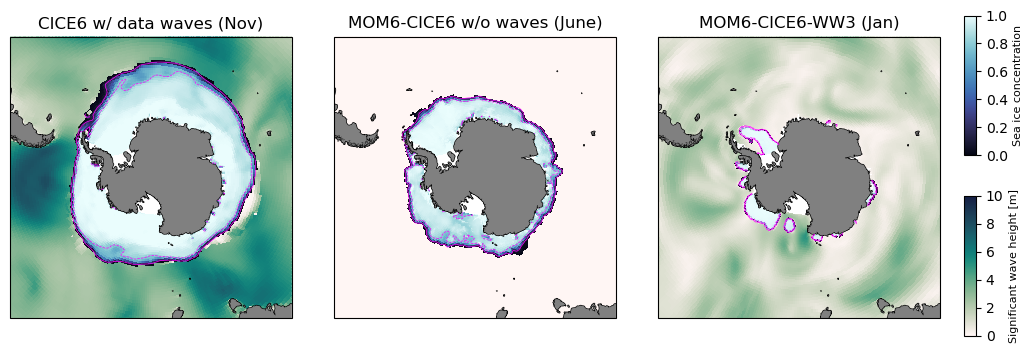

In [23]:
hemisphere = 'south'
aice_threshold = 0.01

fig, axes, projection = basic_axis([1,3], hemisphere=hemisphere)

# Axis 0: Standalone CICE6 with wave propagation
ax_idx = 0
ds_plot = ds0.isel(time=303) #dt[iGroup].isel(time=time_idx-1).copy()

ice_var = 'aice'
settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds0["TLON"]
data["TLAT"] = ds0["TLAT"]

data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds0["TLON"]
data["TLAT"] = ds0["TLAT"]
data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Axis 1: MOM6-CICE6
ax_idx = 1
ds_plot = ds1.isel(time=151) #dt[iGroup].isel(time=time_idx-1).copy()

settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds1["TLON"]
data["TLAT"] = ds1["TLAT"]

data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds1["TLON"]
data["TLAT"] = ds1["TLAT"]
data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Axis 2: MOM6-CICE6-WW3
ax_idx = 2
ds_plot = ds2.isel(time=0)

settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds2["TLON"]
data["TLAT"] = ds2["TLAT"]

aice_mesh = data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds2["TLON"]
data["TLAT"] = ds2["TLAT"]
wave_mesh = data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Add labels
axes[0].set_title("CICE6 w/ data waves (Nov)")
axes[1].set_title("MOM6-CICE6 w/o waves (June)")
axes[2].set_title("MOM6-CICE6-WW3 (Jan)")

# --- Shared colorbars ---
fig.subplots_adjust(right=0.9)

# Top colorbar axis (for aice)
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.35])  # [left, bottom, width, height]
cbar_aice = fig.colorbar(aice_mesh, cax=cax1, orientation="vertical")
cbar_aice.set_label("Sea ice concentration", fontsize=8)

# Bottom colorbar axis (for wave height)
cax2 = fig.add_axes([0.92, 0.1, 0.01, 0.35])
cbar_wave = fig.colorbar(wave_mesh, cax=cax2, orientation="vertical")
cbar_wave.set_label("Significant wave height [m]", fontsize=8)

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/cosima_poster_3maps_aice.png", dpi=300, bbox_inches="tight") 

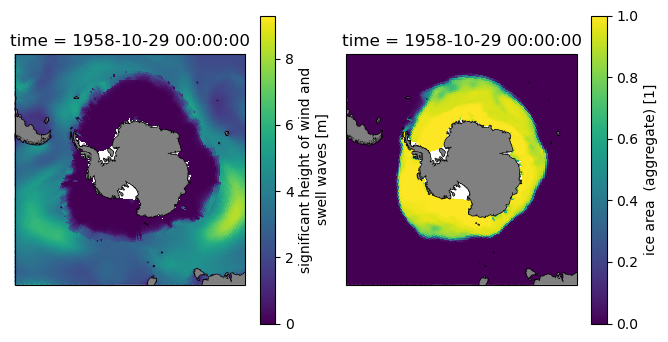

In [24]:
time_idx = 300

fig, axes, projection = basic_axis([1,2], hemisphere=hemisphere)
ds0.isel(time=time_idx)['wave_sig_ht'].plot(ax=axes[0], x="TLON", y="TLAT", transform=ccrs.PlateCarree())

ds0.isel(time=time_idx)['aice'].plot(ax=axes[1], x="TLON", y="TLAT", transform=ccrs.PlateCarree())

In [26]:
# vals0

### Calculate FSDs

In [27]:
NFSD = ds0.NFSD.isel(time=0)
BinWidths, BinLeft, BinRight = ciceBinWidths(NFSD)

bin_edges = np.concatenate([BinLeft, BinRight[-1:]])


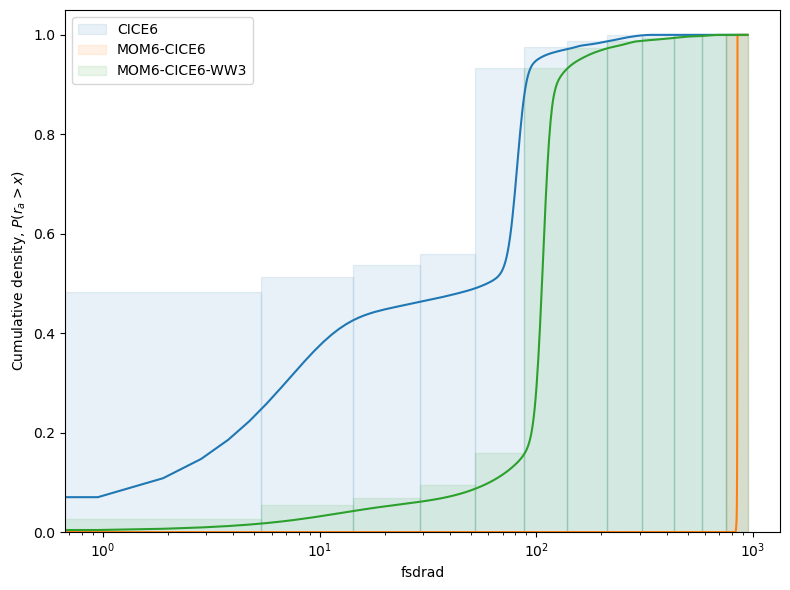

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

aice_threshold = 0.15

# Mask and flatten the data for each dataset
vals0 = ds0.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds0["aice"] > aice_threshold)["fsdrad"].values.flatten()
vals1 = ds1.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds1["aice"] > aice_threshold)["fsdrad"].values.flatten()
vals2 = ds2.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds2["aice"] > aice_threshold)["fsdrad"].values.flatten()

# Drop NaNs
vals0 = vals0[~np.isnan(vals0)]
vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

datasets = [
    (vals0, "CICE6", "C0"),
    (vals1, "MOM6-CICE6", "C1"),
    (vals2, "MOM6-CICE6-WW3", "C2")
]

# Plot histograms with KDE
plt.figure(figsize=(8,6))

for vals, label, color in datasets:
    # Cumulative histogram
    plt.hist(vals, bins=bin_edges, density=True, cumulative=True,
             alpha=0.1, color=color, edgecolor=color, label=label)
    
    # KDE -> CDF
    kde = gaussian_kde(vals)
    x_grid = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    cdf = np.cumsum(kde(x_grid))
    cdf = cdf / cdf[-1]  # normalize to 1
    plt.plot(x_grid, cdf, color=color)

# sns.kdeplot(vals0, color="C0")

# sns.histplot(vals1, bins=bin_edges, stat="cumulative", alpha=0.3, color="C1", label="MOM6-CICE6", edgecolor=None)
# sns.kdeplot(vals1, color="C1")

# sns.histplot(vals2, bins=bin_edges, stat="cumulative", alpha=0.3, color="C2", label="MOM6-CICE6-WW3", edgecolor=None)
# sns.kdeplot(vals2, color="C2")

plt.xscale("log")
# plt.yscale("log")  # log scale on y-axis
plt.xlabel("fsdrad")
plt.ylabel("Cumulative density, $P(r_a > x)$")
plt.legend()
plt.tight_layout()
plt.show()

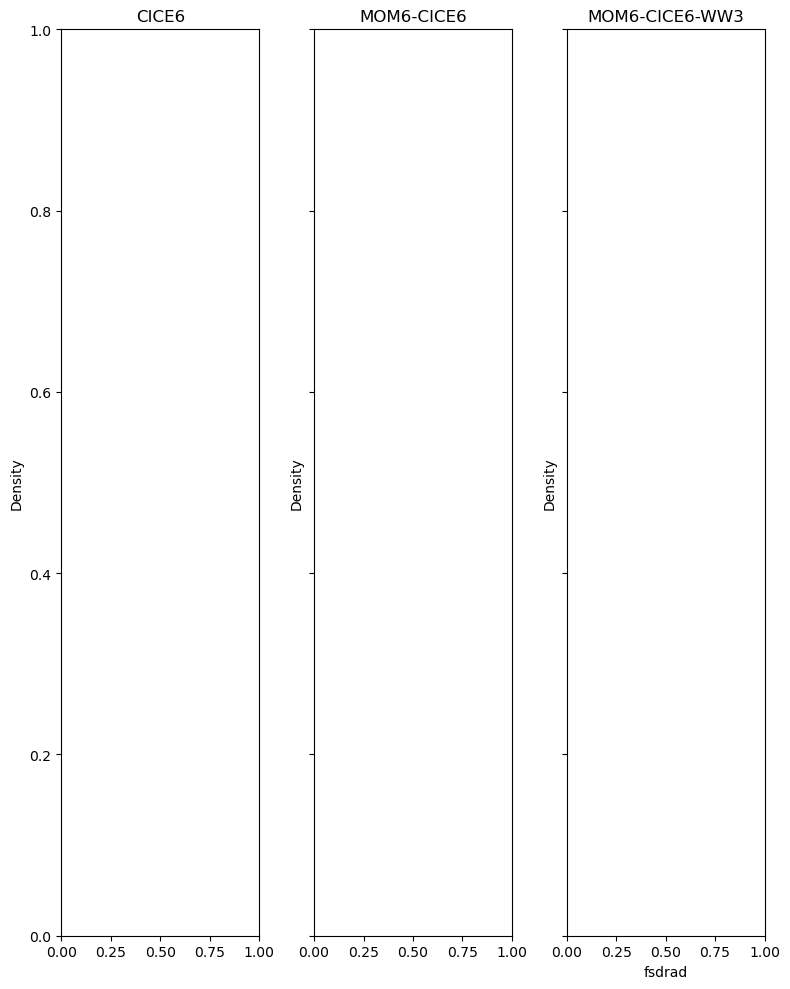

In [29]:
aice_threshold = 0.15

# Mask and flatten the data for each dataset
vals0 = ds0.isel(time=slice(0,28)).where(ds0["aice"] > aice_threshold).where(ds0["TLON"] < 0)["fsdrad"].values.flatten()
vals1 = ds1.isel(time=slice(0,28)).where(ds1["aice"] > aice_threshold).where(ds0["TLON"] < 0)["fsdrad"].values.flatten()
vals2 = ds2.isel(time=slice(0,28)).where(ds2["aice"] > aice_threshold).where(ds0["TLON"] < 0)["fsdrad"].values.flatten()

# Drop NaNs
vals0 = vals0[~np.isnan(vals0)]
vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

datasets = [
    (vals0, "CICE6", "C0"),
    (vals1, "MOM6-CICE6", "C1"),
    (vals2, "MOM6-CICE6-WW3", "C2"),
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 10), sharex=True, sharey=True)

for ax, (vals, label, color) in zip(axes, datasets):
    sns.histplot(vals, stat="density", alpha=0.3,
                 color=color, edgecolor=None, ax=ax)
    # ax.set_xscale("log")
    ax.set_ylabel("Density")
    ax.set_title(label)

axes[-1].set_xlabel("fsdrad")
plt.tight_layout()
plt.show()

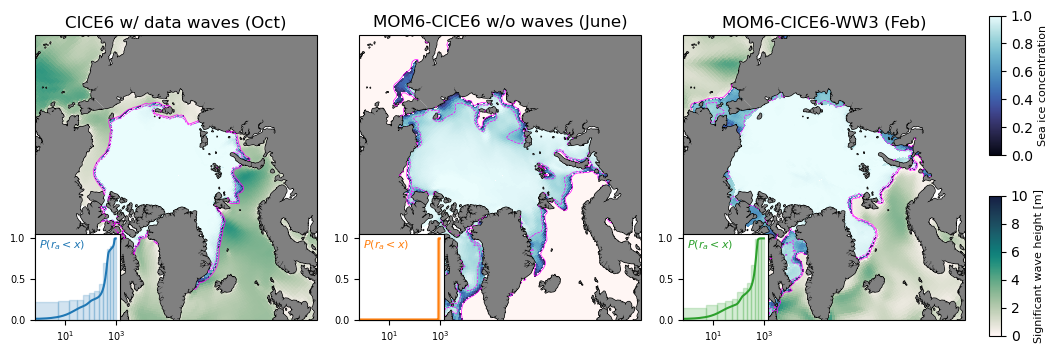

In [32]:
aice_threshold = 0.15
hemisphere = 'north'
fig, axes, projection = basic_axis([1,3], hemisphere=hemisphere)

# Axis 0: Standalone CICE6 with wave propagation
ax_idx = 0
ds_plot = ds0.isel(time=274) #dt[iGroup].isel(time=time_idx-1).copy()

ice_var = 'aice'
settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds0["TLON"]
data["TLAT"] = ds0["TLAT"]

data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds0["TLON"]
data["TLAT"] = ds0["TLAT"]
data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Axis 1: MOM6-CICE6
ax_idx = 1
ds_plot = ds1.isel(time=151) #dt[iGroup].isel(time=time_idx-1).copy()

settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds1["TLON"]
data["TLAT"] = ds1["TLAT"]

data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds1["TLON"]
data["TLAT"] = ds1["TLAT"]
data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Axis 2: MOM6-CICE6-WW3
ax_idx = 2
ds_plot = ds2.isel(time=0)

settings = get_plot_settings(ice_var)
data = ds_plot[ice_var]
data["TLON"] = ds2["TLON"]
data["TLAT"] = ds2["TLAT"]

aice_mesh = data.where(ds_plot["aice"] > aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

data = ds_plot['wave_sig_ht']
settings = get_plot_settings('wave_sig_ht')
data["TLON"] = ds2["TLON"]
data["TLAT"] = ds2["TLAT"]
wave_mesh = data.where(ds_plot["aice"] < aice_threshold).plot(
    ax=axes[ax_idx], x="TLON", y="TLAT",
    cmap=settings.get("cmap"),
    vmin=settings.get("vmin"),
    vmax=settings.get("vmax"),
    transform=ccrs.PlateCarree(),
    add_colorbar=False
)

cs = add_ice_contours(axes[ax_idx], ds_plot, hemisphere, projection)  


# Add labels
axes[0].set_title("CICE6 w/ data waves (Oct)")
axes[1].set_title("MOM6-CICE6 w/o waves (June)")
axes[2].set_title("MOM6-CICE6-WW3 (Feb)")

# --- Shared colorbars ---
fig.subplots_adjust(right=0.9)

# Top colorbar axis (for aice)
cax1 = fig.add_axes([0.92, 0.55, 0.01, 0.35])  # [left, bottom, width, height]
cbar_aice = fig.colorbar(aice_mesh, cax=cax1, orientation="vertical")
cbar_aice.set_label("Sea ice concentration", fontsize=8)

# Bottom colorbar axis (for wave height)
cax2 = fig.add_axes([0.92, 0.1, 0.01, 0.35])
cbar_wave = fig.colorbar(wave_mesh, cax=cax2, orientation="vertical")
cbar_wave.set_label("Significant wave height [m]", fontsize=8)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import gaussian_kde
import numpy as np

if hemisphere == "south":
    vals0 = ds0.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds0["aice"] > aice_threshold)["fsdrad"].values.flatten()
    vals1 = ds1.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds1["aice"] > aice_threshold)["fsdrad"].values.flatten()
    vals2 = ds2.isel(time=slice(0,28)).where(ds0["TLAT"] < 0).where(ds2["aice"] > aice_threshold)["fsdrad"].values.flatten()
else:
    vals0 = ds0.isel(time=slice(0,28)).where(ds0["TLAT"] > 0).where(ds0["aice"] > aice_threshold)["fsdrad"].values.flatten()
    vals1 = ds1.isel(time=slice(0,28)).where(ds0["TLAT"] > 0).where(ds1["aice"] > aice_threshold)["fsdrad"].values.flatten()
    vals2 = ds2.isel(time=slice(0,28)).where(ds0["TLAT"] > 0).where(ds2["aice"] > aice_threshold)["fsdrad"].values.flatten()    

# Drop NaNs
vals0 = vals0[~np.isnan(vals0)]
vals1 = vals1[~np.isnan(vals1)]
vals2 = vals2[~np.isnan(vals2)]

# Prepare the datasets
datasets_vals = [
    (ds0, vals0, "CICE6", "C0"),
    (ds1, vals1, "MOM6-CICE6", "C1"),
    (ds2, vals2, "MOM6-CICE6-WW3", "C2"),
]

# Add CDF insets
for ax_idx, (ds_plot, vals, label, color) in enumerate(datasets_vals):
    vals_clean = vals[~np.isnan(vals)]

    # Create inset axes inside the map axes
    ax_inset = inset_axes(
        axes[ax_idx],
        width="30%", height="30%",
        loc='lower left',           # anchor point in parent axes
        bbox_to_anchor=(0, 0, 1, 1),  # (x0, y0, width, height) relative to parent
        bbox_transform=axes[ax_idx].transAxes,  # use axes coords
        borderpad=0                 # no padding
    )

    # Cumulative histogram
    ax_inset.hist(vals_clean, bins=bin_edges, density=True, cumulative=True,
                  alpha=0.2, color=color, edgecolor=color)

    # KDE -> CDF
    kde = gaussian_kde(vals_clean)
    x_grid = np.linspace(bin_edges[0], bin_edges[-1], 1000)
    cdf = np.cumsum(kde(x_grid))
    cdf = cdf / cdf[-1]  # normalize 0-1
    ax_inset.plot(x_grid, cdf, color=color)

    # Formatting
    ax_inset.set_xscale("log")
    ax_inset.text(0.05, 0.95, "$P(r_a < x)$", transform=ax_inset.transAxes,
                  fontsize=8, fontweight='bold', va='top', ha='left', color=color)
    ax_inset.tick_params(axis='both', which='major', labelsize=7)

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/cosima_poster_3maps_aice_{hemisphere}.png", dpi=300, bbox_inches="tight") 

In [31]:
data

<xarray.DataArray 'wave_sig_ht' (nj: 300, ni: 360)> Size: 864kB
dask.array<getitem, shape=(300, 360), dtype=float64, chunksize=(300, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 8B 1958-01-01T12:00:00
    ulat     (nj, ni) float64 864kB ...
    ulon     (nj, ni) float64 864kB ...
    tlat     (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.153 1.145 1.138
    tlon     (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.395 1.396 1.396
    TLON     (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.96 79.97 79.99
    TLAT     (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      significant height of wind and swell waves
    cell_measures:  area: tarea
    comment:        from attenuated spectrum in ice
    cell_methods:   time: mean
    time_rep:       averaged

In [77]:
model_SIA_SIE_dt_FY1 = calculate_SIA_SIE_model(ds1.isel(time=slice(0,1*365)))
model_SIA_SIE_dt1 = calculate_SIA_SIE_model(ds1.isel(time=slice(10*365,20*365)))

model_SIA_SIE_dt_FY2 = calculate_SIA_SIE_model(ds2.isel(time=slice(0,1*365)))
model_SIA_SIE_dt2 = calculate_SIA_SIE_model(ds2.isel(time=slice(10*365,20*365)))
model_SIA_SIE_dt_FY['si_extent_north']

<xarray.DataArray 'si_extent_north' (time: 28)> Size: 224B
array([11261377.30814985, 11810483.61510048, 12097719.72776173,
       12447515.97004096, 12670026.86218495, 12875635.09063233,
       12973809.95129554, 13034369.05466882, 13108536.20047786,
       13179508.40257313, 13272062.8912908 , 13301378.66141357,
       13354940.44316545, 13361314.54647644, 13459153.9925322 ,
       13517838.72632424, 13527243.93220372, 13571248.35599424,
       13628840.31218697, 13639773.86567858, 13721192.85420104,
       13778781.80138021, 13806529.41914028, 13806193.22733291,
       13818787.43827989, 13852720.36942018, 13898196.96927123,
       13939768.85823385])
Coordinates:
  * time     (time) datetime64[ns] 224B 1958-01-01T12:00:00 ... 1958-01-28T12...

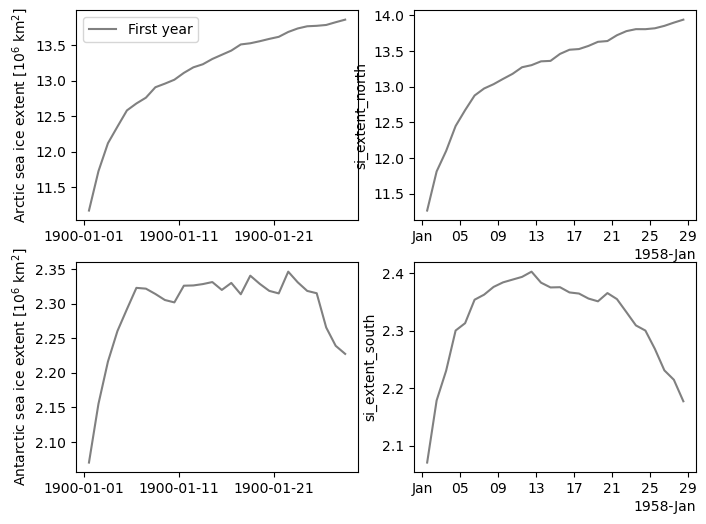

In [88]:
%matplotlib inline
import seaborn as sns
import calendar

cmap = sns.color_palette(n_colors=5)
linewidth = 0.5

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharex=False)

# Arctic
(model_SIA_SIE_dt_FY1['si_extent_north']  * 1e-6).plot(ax=axes[0,0], label="First year", color='gray')
(model_SIA_SIE_dt_FY2['si_extent_north']  * 1e-6).plot(ax=axes[0,1], label="First year", color='gray')
# grouped = model_SIA_SIE_dt['si_extent_north']
# mean = grouped.mean() * 1e-6
# std = grouped.std() * 1e-6
# mean.plot(ax=axes[0], label="Mean after 10 year spinup")
# axes[0].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
# (obs_extent_dt["cdr_nh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[0], label="CDR", color='k')

# Antarctic
(model_SIA_SIE_dt_FY1['si_extent_south'] * 1e-6).plot(ax=axes[1,0], label="First year", color='gray')
(model_SIA_SIE_dt_FY2['si_extent_south'] * 1e-6).plot(ax=axes[1,1], label="First year", color='gray')
# grouped = model_SIA_SIE_dt['si_extent_south'].groupby("time.month")
# mean = grouped.mean() * 1e-6
# std = grouped.std() * 1e-6
# mean.plot(ax=axes[1], label="Mean")
# axes[1].fill_between(mean['month'], mean - std, mean + std, alpha=0.3, label="±1 SD")
# (obs_extent_dt["cdr_sh"].ds.cdr_area.groupby("time.month").mean() * 1e-6).plot(ax=axes[1], label="CDR", color='k')

# Labels
axes[0,0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
axes[1,0].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

axes[0,0].legend()

for ax in axes.flatten():
    # ax.set_xticks(range(1, 13))
    # ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/SIE_two_run_{experiment1}_{experiment2}.png", dpi=600, bbox_inches="tight") 
plt.show()

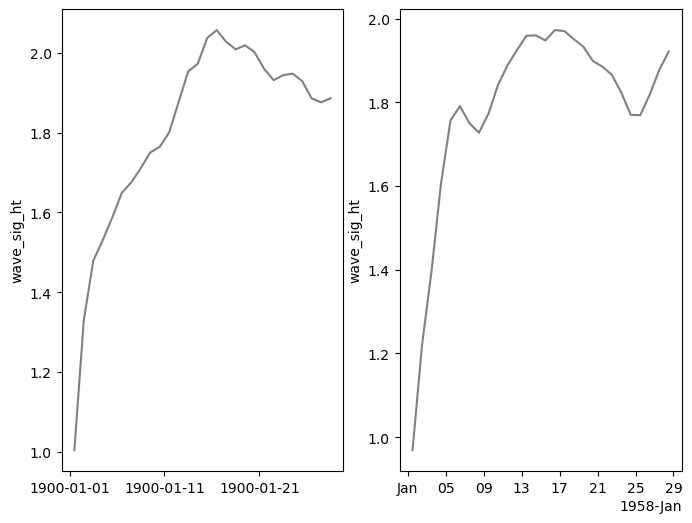

In [93]:
%matplotlib inline
import seaborn as sns
import calendar

cmap = sns.color_palette(n_colors=5)
linewidth = 0.5

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6), sharex=False)

# Arctic
ds1['wave_sig_ht'].mean(dim=['ni', 'nj']).plot(ax=axes[0], label="First year", color='gray')
ds2['wave_sig_ht'].mean(dim=['ni', 'nj']).plot(ax=axes[1], label="First year", color='gray')


# Labels
# axes[0,0].set_ylabel("Arctic sea ice extent [10$^6$ km$^2$]")
# axes[1,0].set_ylabel("Antarctic sea ice extent [10$^6$ km$^2$]")

# axes[0,0].legend()

for ax in axes.flatten():
    # ax.set_xticks(range(1, 13))
    # ax.set_xticklabels([calendar.month_abbr[m] for m in range(1, 13)])
    ax.set_xlabel('')

plt.savefig(f"/home/566/nd0349/access-om3-analysis/figures/SWH_two_run_{experiment1}_{experiment2}.png", dpi=600, bbox_inches="tight") 
plt.show()

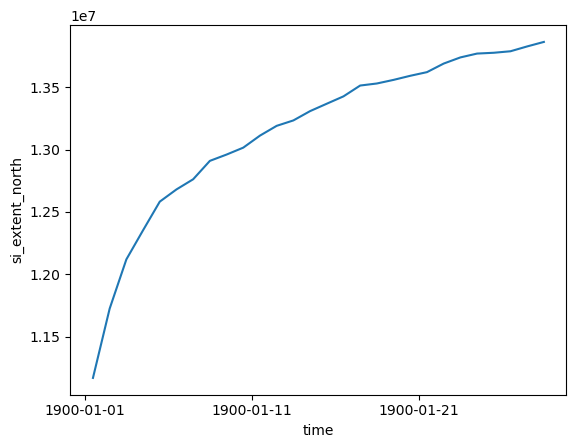

In [83]:
model_SIA_SIE_dt_FY1['si_extent_north'].plot()

In [80]:
model_SIA_SIE_dt_FY2['time']

<xarray.DataArray 'time' (time: 28)> Size: 224B
array(['1958-01-01T12:00:00.000000000', '1958-01-02T12:00:00.000000000',
       '1958-01-03T12:00:00.000000000', '1958-01-04T12:00:00.000000000',
       '1958-01-05T12:00:00.000000000', '1958-01-06T12:00:00.000000000',
       '1958-01-07T12:00:00.000000000', '1958-01-08T12:00:00.000000000',
       '1958-01-09T12:00:00.000000000', '1958-01-10T12:00:00.000000000',
       '1958-01-11T12:00:00.000000000', '1958-01-12T12:00:00.000000000',
       '1958-01-13T12:00:00.000000000', '1958-01-14T12:00:00.000000000',
       '1958-01-15T12:00:00.000000000', '1958-01-16T12:00:00.000000000',
       '1958-01-17T12:00:00.000000000', '1958-01-18T12:00:00.000000000',
       '1958-01-19T12:00:00.000000000', '1958-01-20T12:00:00.000000000',
       '1958-01-21T12:00:00.000000000', '1958-01-22T12:00:00.000000000',
       '1958-01-23T12:00:00.000000000', '1958-01-24T12:00:00.000000000',
       '1958-01-25T12:00:00.000000000', '1958-01-26T12:00:00.000000000',
       '1958-01-27T12:00:00.000000000', '1958-01-28T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 224B 1958-01-01T12:00:00 ... 1958-01-28T12...
Attributes:
    long_name:  time
    bounds:     time_bounds

In [91]:
ds1['wave_sig_ht'].mean(dim=['ni', 'nj'])

<xarray.DataArray 'wave_sig_ht' (time: 28)> Size: 224B
dask.array<mean_agg-aggregate, shape=(28,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 224B 1900-01-01 12:00:00 ... 1900-01-28 12:00:00

### Compare a few runs in SIE and against OBS

In [69]:

def open_by_experiment(exp_name, vars, VARS_2D, RUN_DICT, catalog):
    """Concatenate any datasets provided for this experiment into one ds, and add area and geo coordinates"""

    print(f"Loading... {exp_name}")
    
    if RUN_DICT[exp_name]["model"] in ["access-om2", "access-om3"]:
        # If the experiment is in the Catalog then get the data from there
        # get the data for each run of this config
        cice_ds = xr.concat(
            [open_by_name(iName, vars, catalog) for iName in [RUN_DICT[exp_name]['experiment']]], dim="time"
        )
    
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.merge(
            [
                xr.open_dataset(
                    catalog[RUN_DICT[exp_name]['experiment']]
                    .search(variable=iVar)
                    .df.path[0]
                    # path of the first file with the area field, the geolon field and the geolat field
                ).drop_vars("time")
                for iVar in VARS_2D
            ]
        )
    
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
    
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
    
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
    
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
    
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
    
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    
    elif RUN_DICT[exp_name]["model"] == "access-om2-dev":
        # Else, it is a development experiment and stored on ps29
        base_dir = f"/g/data/ps29/nd0349/runs/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['experiment']}/"
        output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
        # Extract most recent simulation
        if output_dirs:
            output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
            output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
        else:
            output_number = "000"  # Default if no directories exist

        most_recent_file = False
        if most_recent_file:
            print(f"Output folder: {output_number}")
            files = sorted(glob.glob(file_pattern))
        else:
            all_files = []
            for output_dir in output_dirs:
                file_pattern = os.path.join(output_dir, "ice/OUTPUT/", "iceh.????-??.nc")
                all_files.extend(glob.glob(file_pattern))
            files = sorted(all_files)
        
        # path = os.path.join(base_dir, f"output{output_number}", "ice/OUTPUT/")
        # file_pattern = os.path.join(path, "iceh.????-??.nc")
        # files = sorted(glob.glob(file_pattern))
        # file_list = sorted(glob.glob(file_pattern))
        # print(file_pattern)
        # print(files)
        sample_ds = xr.open_mfdataset(files[0],combine="by_coords")

        # List of variables to keep
        keep_vars = ["TLAT", "TLON", "time"] + vars
        
        drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
        
        cice_ds = xr.open_mfdataset(
            files, 
            combine="by_coords", 
            decode_timedelta=False,
            drop_variables=drop_vars  # Now using the correct list
        )
        
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
        
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)


    
    elif RUN_DICT[exp_name]["model"] == "access-om3-dev":
        # Else, it is a development experiment and stored on ps29
        most_recent_file = False
        run_status = 'archive' # 'archive' or 'work'
        if run_status == 'work':
            print("Using work directory")
            base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/work/{RUN_DICT[exp_name]['experiment']}/"
            file_pattern = os.path.join(base_dir, "access-om3.cice.1mon.mean.????-??.nc")
        else:
        
            base_dir = f"/g/data/ps29/nd0349/runs/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['experiment']}/"
            # base_dir = f" /g/data/ps29/nd0349/access-om2/archive/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['experiment']}/"
           
            output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
            # Extract most recent simulation
            if output_dirs:
                output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
                output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
            else:
                output_number = "000"  # Default if no directories exist
            
            file_pattern = os.path.join(base_dir, f"output{output_number}", "access-om3.cice.1mon.mean.????-??.nc")

        if most_recent_file:
            print(f"Output folder: {output_number}")
            files = sorted(glob.glob(file_pattern))
        else:
            all_files = []
            for output_dir in output_dirs:
                file_pattern = os.path.join(output_dir, "access-om3.cice.1mon.mean.????-??.nc")
                all_files.extend(glob.glob(file_pattern))
            files = sorted(all_files)
        
        
        sample_ds = xr.open_mfdataset(files[0],combine="by_coords")

        # List of variables to keep
        keep_vars = ["TLAT", "TLON", "time"] + vars
        
        drop_vars = [var for var in sample_ds.variables if var not in keep_vars]
        
        cice_ds = xr.open_mfdataset(
            files, 
            chunks={'ni':-1,'nj':-1,'time':120},
            combine="by_coords", 
            decode_timedelta=False,
            drop_variables=drop_vars  # Now using the correct list
        )
        
        # We also want the area/lat/lon fields, but these are not time dependent.
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc",
                                    drop_variables=["ulat","ulon"],
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean", "tarea": "area_t", "tlat": "geolat_t", "tlon": "geolon_t"}))
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]

        def radians_to_degrees(da):
            return da * (180 / np.pi)
        
        # Apply conversion efficiently while handling Dask arrays
        area_ds = area_ds.assign_coords(
            geolat_t=xr.apply_ufunc(radians_to_degrees, area_ds.geolat_t, dask="parallelized"),
            geolon_t=xr.apply_ufunc(radians_to_degrees, area_ds.geolon_t, dask="parallelized")
        )

        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
# plt.pcolormesh(all_data[1].geolon_t, all_data[1].geolat_t, all_data[1], shading='auto')

        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )


        
        # cice timestamps are also misleading:
        # cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)

    elif RUN_DICT[exp_name]["model"] == "access-om3-wav-dev":
        # ACCESS-OM3 development
        base_dir = f"/scratch/ps29/nd0349/{exp_name[0:10].lower()}/archive/{RUN_DICT[exp_name]['experiment']}/"
        output_dirs = glob.glob(os.path.join(base_dir, "output[0-9][0-9][0-9]"))
        
        # # Extract most recent simulation
        # if output_dirs:
        #     output_number = max(int(d[-3:]) for d in output_dirs)  # Extract last 3 digits
        #     output_number = f"{output_number:03d}"  # Ensure it stays in 000 format
        # else:
        #     output_number = "000"  # Default if no directories exist
        
        # path = os.path.join(base_dir, f"output{output_number}")
        # file_pattern = os.path.join(path, "access-om3.cice.*.nc")
        # files = sorted(glob.glob(file_pattern))
        # file_list = sorted(glob.glob(file_pattern))

        file_pattern = os.path.join(base_dir, "output[0-9][0-9][0-9]", "access-om3.cice.*.nc")
        file_list = sorted(glob.glob(file_pattern))
        print(file_list)
        # Read in data
        if file_list:
            cice_ds = xr.open_mfdataset(file_list, combine="by_coords")
        else:
            print("No matching files found.")


        # Read in data
        # cice_ds = xr.open_mfdataset(file_list, combine="by_coords")
        # cice_ds['aice_m'] = cice_ds['aice'].resample(time='ME').max()
        cice_ds['aice_m'] = cice_ds['aice']
        area_ds = xr.open_mfdataset("/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc", 
                                    combine="by_coords")
        area_ds = area_ds.rename(({"ni": "xt_ocean", 
                                   "nj": "yt_ocean", 
                                   "tarea": "area_t", 
                                   "tlat": "geolat_t", 
                                   "tlon": "geolon_t"})
                                )
        # VARS_2D = ["area_t", "geolat_t", "geolon_t"]
        
        # Label the lats and lons
        cice_ds.coords["ni"] = area_ds["xt_ocean"].values
        cice_ds.coords["nj"] = area_ds["yt_ocean"].values
        
        # Copy attributes for cf compliance
        cice_ds.ni.attrs = area_ds.xt_ocean.attrs
        cice_ds.nj.attrs = area_ds.yt_ocean.attrs
        
        cice_ds = cice_ds.rename(({"ni": "xt_ocean", "nj": "yt_ocean"}))
        
        # Add the geolon, geolat, and area as extra co-ordinates fields from area_t
        
        cice_ds = cice_ds.assign_coords(
            {
                "geolat_t": area_ds.geolat_t,
                "geolon_t": area_ds.geolon_t,
                "area_t": area_ds.area_t,
            }
        )
        
        # cice timestamps are also misleading:
        cice_ds["time"] = cice_ds.time.to_pandas() - timedelta(minutes=1)
    print(f"{exp_name} loaded.")
    return cice_ds

In [70]:
# si_dt['ACCESS-OM2-10 JRA55-do IAF [dev]']

In [59]:
%%time
catalog = cat.access_nri

RUN_DICT = {
    # "ACCESS-OM2-10 JRA55-do IAF OMIP2": {"experiment": "1deg_jra55_iaf_omip2_cycle1", "model": "access-om2"},
    # "ACCESS-OM2-10 JRA55-do RYF [dev]": {"experiment": "1deg_jra55_ryf-experiment-054ea9ee", "model": "access-om2-dev"},
    # "ACCESS-OM2-10 JRA55-do IAF [dev]": {"experiment": "1deg_jra55_iaf-experiment-70159801", "model": "access-om2-dev"},
    # "ACCESS-OM3-10 JRA55-do RYF [dev]": {"experiment": "1deg_mom6_cice6_ryf", "model": "access-om3-dev"},
    # "ACCESS-OM3-10 JRA55-do IAF [dev]": {"experiment": "1deg_mom6_cice6_iaf", "model": "access-om3-dev"},
    "ACCESS-OM3-025 JRA55-do IAF [dev]": {"experiment": "mom6-cice6_ryf_025deg_rel", "model": "access-om3-dev"},
    "ACCESS-OM3-10-wave JRA55-do IAF [dev]": {"experiment": "wav_iaf_rel", "model": "access-om3-wav-dev"},
}

VARS = ["aice_m", "hi_m" ]  # ice area fraction or sea ice concentration, ice thickness averaged by grid cell area
VARS_2D = ["area_t", "geolat_t", "geolon_t"]

si_name_ds_pairs = [(iRun, open_by_experiment(iRun, VARS, VARS_2D, RUN_DICT, catalog)) for iRun in RUN_DICT.keys()]

si_dt = DataTree.from_dict(dict(si_name_ds_pairs))
model_area_dt = si_dt.map_over_datasets(sea_ice_area_model_sh)

ValueError: conflicting sizes for dimension 'ni': length 360 on 'ni' and length 1440 on {'time': 'hi_m', 'nj': 'hi_m', 'ni': 'hi_m'}

In [68]:
import intake
experiment1 = "1deg_jra55_iaf-experiment-70159801"
experiment2 = "mom6-cice6_iaf_rel"
# experiment1 = "mom6-cice6_ryf_rel_wav"
# experiment2 = "wav_iaf_rel"
model1 = "access-om2"
model2 = "access-om3"

esm_datastore1 = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{experiment1}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ],
)
esm_datastore2 = intake.open_esm_datastore(
    f"/g/data/ps29/nd0349/runs/{model}/archive/{experiment2}/intake_esm_ds.json", 
    columns_with_iterables=[
            "variable",
            "variable_long_name",
            "variable_standard_name",
            "variable_cell_methods",
            "variable_units",
    ],
)

FileNotFoundError: [Errno 2] No such file or directory: '/g/data/ps29/nd0349/runs/access-om3/archive/1deg_jra55_iaf-expt-70159801/intake_esm_ds.json'

In [5]:
esm_datastore_filtered1 = esm_datastore1.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], #require_all_on="path"
)
esm_datastore_filtered1

In [6]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
var = 'aice'
ds1 = esm_datastore_filtered1.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]

grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
grid_ds

# Add grid to dataset
ds1['TLON'] = np.degrees(grid_ds['tlon'])
ds1['TLAT'] = np.degrees(grid_ds['tlat'])
ds1

CPU times: user 7.96 s, sys: 1.95 s, total: 9.91 s
Wall time: 34.6 s


<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...

In [7]:
esm_datastore_filtered2 = esm_datastore2.search(
    variable=["aice", "hi", "fsdrad", "wave_sig_ht"], require_all_on="path"
)
esm_datastore_filtered2

In [8]:
%%time
xarray_open_kwargs = {"chunks": {"time": 12, "nj": -1, "ni": -1}}
var = 'aice'
ds2 = esm_datastore_filtered2.to_dask(xarray_open_kwargs=xarray_open_kwargs)#[var]
# Add grid to dataset
ds2['TLON'] = np.degrees(grid_ds['tlon'])
ds2['TLAT'] = np.degrees(grid_ds['tlat'])
ds2

CPU times: user 310 ms, sys: 38.8 ms, total: 349 ms
Wall time: 738 ms


<xarray.Dataset> Size: 102MB
Dimensions:      (time: 28, nj: 300, ni: 360)
Coordinates:
  * time         (time) datetime64[ns] 224B 1958-01-01T12:00:00 ... 1958-01-2...
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 24MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/20)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  This year has 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,,,time: mean,time: mea...
    intake_esm_attrs:variable_units:          days since 1958-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_XXXX_XX_XX.1day

In [9]:
# var = "aice"

# esm_datastore_filtered = esm_datastore.search(
#     variable=["aice_m", "fsdrad_m", "wave_sig_ht_m"], frequency="1mon", require_all_on="path"
# )
ds1

<xarray.Dataset> Size: 43GB
Dimensions:      (time: 12410, nj: 300, ni: 360)
Coordinates:
  * time         (time) object 99kB 1906-01-01 12:00:00 ... 1939-12-31 12:00:00
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB ...
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
Dimensions without coordinates: nj, ni
Data variables:
    hi           (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    aice         (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    fsdrad       (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    wave_sig_ht  (time, nj, ni) float64 11GB dask.array<chunksize=(12, 300, 360), meta=np.ndarray>
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         day_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,,,,,,,,,,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1day_mean_XXXX_...